HR Predictive Plots and Generalized Linear Models 
=========

Igor Marfin <igor.marfin@unister.de> 


-----------

## Outline


* Introduction
* Initialization 
* Train and Test Data Reading
* Plots and Linear Regression Analysis    
    * Outlier detection
    * Outlier cleaning the train dataset
    * Simplified models
    * Correlation Matrix
    * OLS Model
    * GLM with the Gaussian family
    * Regression Graphics
    * The regularized OLS with L1-penalty terms
    * Polynomial models of the order=2 and order=3
* GLM Predictions of `total_price` on the test data
    * 'Scaling' Effect in the predictions
    * Selection of the best customers with Generelazed Linear Model
* Comparison of predictions from DecisionTrees and GLM
* Cross-validation of the GLM model
* Conclusions


## Introduction
-------------------------------

When it comes to building a classification/regression algorithm, analysts have a broad range of open source options to choose from. We are going to try to apply several algorithms to predict the *total price*  of the customer who booked a hotel online. We assume that this total price is a predictor of the probability to book something:

$$  \text{Pr(booking)} \sim \alpha\times totalprice + \beta$$




Thus our aim is to model *total price* and use it as a qualitive selector of the customers for the **Mail Printing** service.











## Initialization
---------------------------------


One needs to *import* properly defined modules to make this analysis.  First, we would like to make automatic
numbering the sections.


In [1]:
#%install_ext https://github.com/dpsanders/ipython_extensions/tree/master/section_numbering/secnum.py

In [2]:
%load_ext secnum
%secnum

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


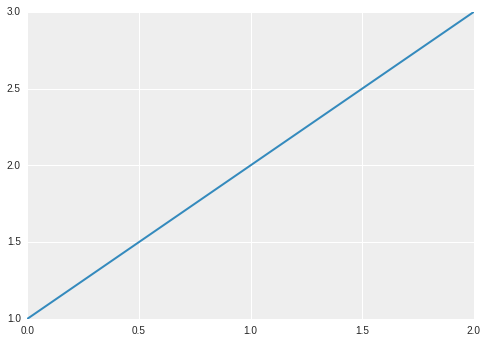

In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline



import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl


# a plotter module
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd

from Dataframe import Dataframe

# Imputer
import DataFrameImputer # my own imputer


# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )



prefix='HR_predictive_'
plots_dir = 'plots/'

ion()

# test plotting style'
from pylab import *
plot([1,2,3])
show()


import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)



...creating directory, where  we are going to store some plots 

In [2]:
%%bash

# create a directory for control plots 
mkdir plots 2> /dev/null

### Reading training data
----------------------------------

Ok. Now we can read data of customers, which were chosen as the best one last years. These customers had got 'lucky' mails with 'gutscheine' and bought products of Unister afterwards.

In [2]:
# -*- coding: utf-8 -*-


# 1. a place, where data are stored  and a name of the training set
data_dir = 'data/'
file_for_training = 'HR_Guschein_Booker_150518' 


# 2. reading the csv file and creating the dataframe
# also, we want to know CPU time of this operation
%time df=Dataframe(data_dir+file_for_training+'.csv',None)


'''
# 3. finding fake data:
    with 'total_price'<1Euro OR 'book_duration'<0 days OR 'reise_dauer'<0 days OR 'Buch_anzahl'<1 
     OR 'no_of_persons<1'
'''

criteria_index=df.dataset.loc[
    (df.dataset['total_price'] < 1) |
    (df.dataset['book_duration'] < 0) |
    (df.dataset['reise_dauer'] < 0) |
    (df.dataset['Buch_anzahl'] < 1) |
    (df.dataset['no_of_persons'] < 1)     
    ].index


fake_data=df.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "fake data" criteria'%len(fake_data)
print '<>'*30,'\n\n'

if (len(fake_data))>0:    

    # 3.2 droping fake data from the original dataframes
    df.dataset=df.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for final stage'%len(df.dataset)
print '<>'*30,'\n\n'
    
    

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 20.7 ms


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 0 entries which are satisfied to "fake data" criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 6064 entries which are passed for final stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




Before we do imputting missed (aka NaN) data  (empty fields in some entries... ), we would like to replace all 'NaN' string fields ( we call them string categores) by the keyword='UNKNOWN'

In [3]:
# 4. doing replacement only string fields
for column in df.dataset.columns:
    if ( 
            pd.isnull(df.dataset[column]).any() and 
            df.dataset[column].dtype == dtype('object') # string's type is 'object'
        ): 
            df.dataset[column].fillna('UNKNOWN', inplace=True)



In [4]:
#5. filling missed (NaB) data: only numerical NaN data will be imputted
print 'Does age field contains NaNs?', pd.isnull(df.dataset['age']).any()
df.dataset = DataFrameImputer.DataFrameImputer().fit(df.dataset).transform(df.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df.dataset['age']).any()



# for sanity 
df.dataset=df.dataset.dropna()

Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


### Reading test data
----------------------------------

Ok. Now we can read data of customers, which should be chosen at the end of May 2015 for **Mailing Service**.
The procedure lookes pretty much the same as for the case of the *training* data except only one additional preseletion:


 
        # 3.2 here is an additional preselection: 
       '''         droping all customers which are outliers:
                who spendings lie in the tails of the distributions of 'total_price' -->
                <= 10% or >=90%
               
             Why are we doing that?    
             We think that people, whose 'total_price' is too low at this moment, have bought some products
             occassionaly. It was more likely the first-last buying.
             
             Also people who spent too much money to this moment, perhaps, have 'performed' all their hollidays planned in
             this year.

          '''



In [5]:
# -*- coding: utf-8 -*-


# 1. a place, where data are stored  and a name of the testing set
data_dir = 'data/'
file_for_testing = 'Nur_HR_Kunden_150518'


# 2. reading the csv file and creating the dataframe
# also, we want to know CPU time of this operation
%time df_test=Dataframe(data_dir+file_for_testing+'.csv',None)



'''
# 3. finding fake data:
    with 'total_price'<1Euro OR 'book_duration'<0 days OR 'reise_dauer'<0 days OR 'Buch_anzahl'<1 
     OR 'no_of_persons<1'
'''

criteria_index=df_test.dataset.loc[
    (df_test.dataset['total_price'] < 1) |
    (df_test.dataset['book_duration'] < 0) |
    (df_test.dataset['reise_dauer'] < 0) |
    (df_test.dataset['Buch_anzahl'] < 1) |
    (df_test.dataset['no_of_persons'] < 1)     
    ].index


fake_data=df_test.dataset.loc[criteria_index,:]

print '\n\n','<>'*30
print 'Found %d entries which are satisfied to "fake data" criteria'%len(fake_data)
print '<>'*30,'\n\n'

if (len(fake_data))>0:    

    # 3.2 droping fake data from the original dataframes
    df_test.dataset=df_test.dataset.drop(criteria_index)


print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    

# 3.2 here is an additional preselection: 
'''         droping all customers which are outliers:
                who spending lie in the tails of the distributions of 'total_price' -->
                <= 10% or >=90%
                
             Why are we doing that?    
             We think that people, whose 'total_price' is too low at this moment, have bought some products
             occassionaly. It was more likely the first-last buying.
             
             Also people who spent too much money to this moment, perhaps, have 'performed'  all their hollidays planned in
             this year.

'''


#min_10=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['10%']
#max_90=df_test.dataset['total_price'].describe(percentiles=[.05,.1,.25,.5,.75,.90,.95])['90%']
#
#criteria_index=df_test.dataset.loc[
#    (df_test.dataset['total_price'] < min_10) | 
#    (df_test.dataset['total_price'] > max_90) 
#    ].index
#
#
#outliers=df_test.dataset.loc[criteria_index,:]
#
#print '\n\n','<>'*30
#print 'Found %d entries which are satisfied to "outlier"  criteria'%len(outliers)
#print '<>'*30,'\n\n'
#
#if (len(outliers))>0:
#
#    # drop fake data from the original dataframes
#    df_test.dataset=df_test.dataset.drop(criteria_index)
#

print '\n\n','<>'*30
print 'Total data have %d entries which are passed for the next stage'%len(df_test.dataset)
print '<>'*30,'\n\n'
    
    
# 4. doing replacement only string fields
for column in df_test.dataset.columns:
    if ( 
            pd.isnull(df_test.dataset[column]).any() and 
            df_test.dataset[column].dtype == dtype('object') # string's type is 'object'
        ): df_test.dataset[column].fillna('UNKNOWN', inplace=True)


#5. filling missed (NaB) data: only numerical NaN data will be imputted
print 'Does age field contains NaNs?', pd.isnull(df_test.dataset['age']).any()
df_test.dataset = DataFrameImputer.DataFrameImputer().fit(df_test.dataset).transform(df_test.dataset)
print 'Does age field contains NaNs after imputting?', pd.isnull(df_test.dataset['age']).any()

# for sanity 
df_test.dataset=df_test.dataset.dropna()

CPU times: user 1.03 s, sys: 112 ms, total: 1.14 s
Wall time: 1.14 s


<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Found 1772 entries which are satisfied to "fake data" criteria
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 465579 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 




<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Total data have 465579 entries which are passed for the next stage
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><> 


Does age field contains NaNs? True
Does age field contains NaNs after imputting? False


## Plots
------------------------


Before we start, we define the folowing color map in our figures to distinguish plots:


    color_map = {
                    'train dataset': 'blue',
                    'test dataset': 'red'
    
                }


First, we are interested to understand if the modeling of the best customer of 2015 makes sense: 

    Are the 'total_prices'  differenent for this year customers and best customers of previuos years?





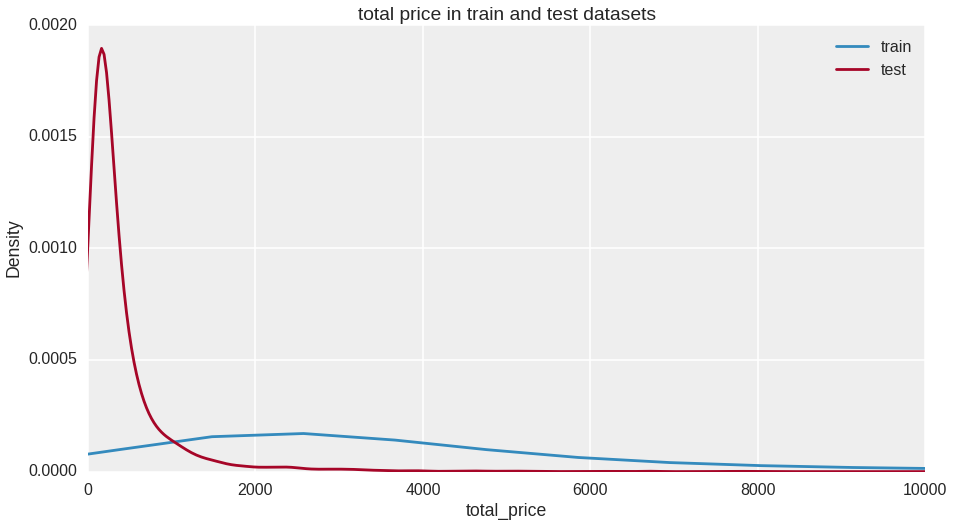

In [6]:
sns.set_context("poster")
plt.figure(figsize=(15,8))

train_price =df.dataset['total_price']

# randomly pick up the same number as in the train case of 'total_price' values 
test_price=df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),'total_price']


train_price.plot(kind='kde',xlim=(0,10000),legend=True,label='train')
test_price.plot(kind='kde',xlim=(0,10000),legend=True,label='test')
pl.xlabel('total_price')
pl.title('total price in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'total_price'+'.png')

It looks pretty interestng: the differences for 'mean' and 'median' of distributions are

In [7]:
print 'median diff: %.3f'%(train_price.median()-test_price.median())
print 'mean diff: %.3f'%(train_price.mean()-test_price.mean())


median diff: 2519.710
mean diff: 3343.608


So, it will be a nice test of our modeling:
    
the median value of the delta (the quantity are used to select customers) is expected to be
$$ median(\delta = total\_price\_predicted - total\_price) \sim 2500$$
    
i.e if $\delta \geq 2500$,  it's more likely that this customer buys some product later.
    

To make a simple linear analysis, we need to know what features are presented in the datasets:

In [12]:
pd.DataFrame(df.dataset.columns,columns=['features'])

features
0       single_price
1      book_duration
2       booking_date
3           p_status
4         Kunde_comp
5            orderid
6             source
7         CustomerID
8             portal
9            s_title
10          s_anrede
11         ClusterID
12               age
13       total_price
14       reise_dauer
15     no_of_persons
16             stars
17       Buch_anzahl
18           zip_std
19          city_std
20        reise_land
21        hotel_name
22  gutscheinnutzung


Let's go further. We need to examine a set of 'simplified' linear regression models of *total_price* on the train and 
test datasets. What are the *simplified* models we should consider? I believe that the following correlations exist:


* total_price  ~ reise_dauer
* total_price  ~ age
* total_price  ~ no_of_persons
* total_price  ~ stars






### Total_price ~ reise_dauer


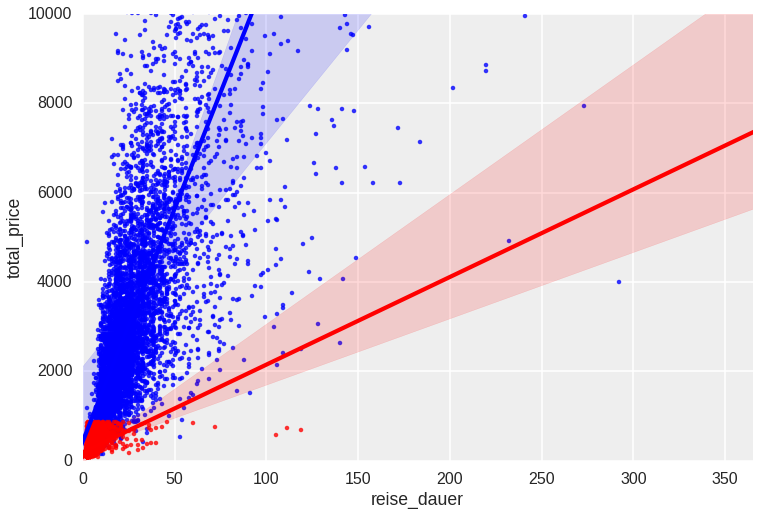

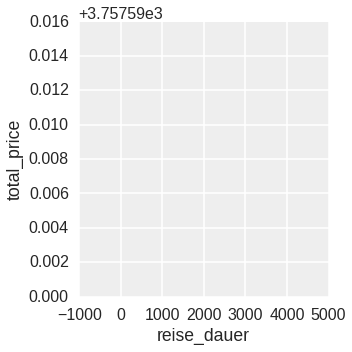

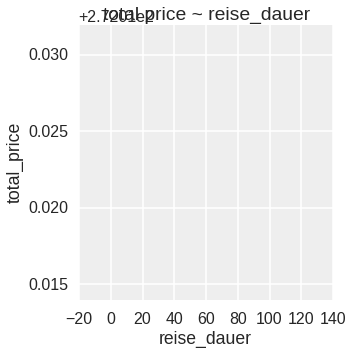

In [9]:
# total_price  ~ reise_dauer
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))


np.random.seed(9221999)
sns.lmplot('reise_dauer','total_price',df.dataset,ax=axes,color='b',label='train')
sns.lmplot('reise_dauer','total_price',df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:],color='r',ax=axes,label='test')

axes.set_ylim(0,10000) #set limits on total_price:(0€,10Ki€)
axes.set_xlim(0,365) # set limits on reise_dauer:(0day,365 days = 1 year)

plt.title('total price ~ reise_dauer')
plt.savefig(plots_dir+prefix+'total_price_reisedaure'+'.png')


There are two important things concluded from the previous plot:


* There are non-zero correlations. They are different for *test* and *train* datasets
* We see a few outliers of the *red* scatter plot: where reise_dauer is about 50
* The same (outliers) is valid for *blue* (test) curve if we remove limits on values of x- and y-axises


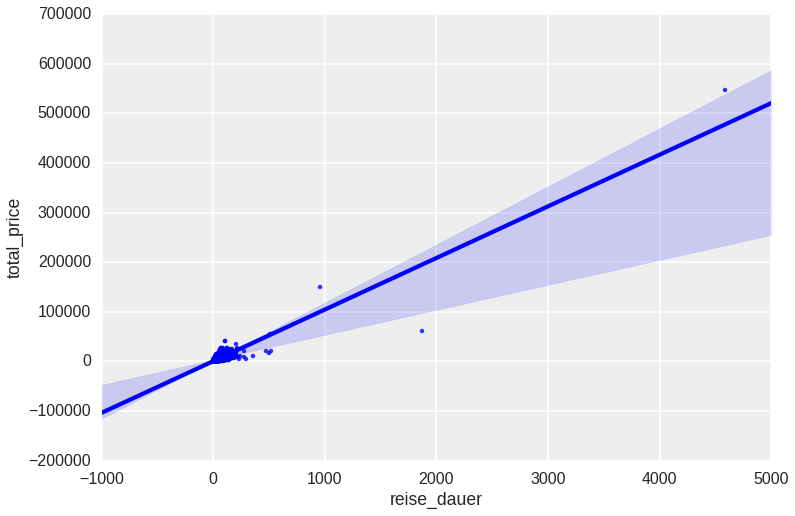

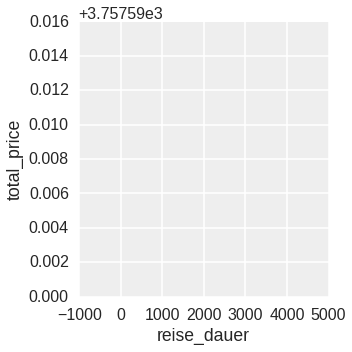

In [10]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))
sns.lmplot('reise_dauer','total_price',df.dataset,ax=axes,color='b',label='train')


The outliers should be removed from the train dataset. Why that? Because if we  make a linear analysis later, the coefficients obtained will be not correct due to presence of outliers. Thus it decrease the prediction power of the model.



### Outlier detection
------------------------------


Here we consider the *simplified* model $$total\_price \sim reise\_dauer$$ and the ways of outlier detection.

In [12]:
# find outliers in 1D space: total_price or reise_dauer
# it is just finding, and not removing the outliers

train_total_price,train_reise_dauer = df.dataset['total_price'].as_matrix(),df.dataset['reise_dauer'].as_matrix()


# outliers values
print '10 highest train total_prices:  ', train_total_price[np.argsort(-train_total_price)[:10]]
print '10 highest train reise_dauer:  ', train_reise_dauer[np.argsort(-train_reise_dauer)[:10]]


# the highest outlier: the 'king' of outliers
i_max_reise_dauer = np.argmax(train_reise_dauer)
i_max_total_price = np.argmax(train_total_price)

print '\n\nSample #%d has the highest total price'%i_max_total_price
print 'Sample #%d has the largest reise dauer'%i_max_reise_dauer

i_max_outlier=i_max_reise_dauer

print '\n \nthe index lists of outliers: '
print 'in total prices:   ',np.argsort(-train_total_price)[:10]
print 'in reise dauer:   ',np.argsort(-train_reise_dauer)[:10]
print '\n\nintersection of index lists:   ',np.intersect1d(np.argsort(-train_total_price)[:10],np.argsort(-train_reise_dauer)[:10])



10 highest train total_prices:   [ 546576.221  149673.78    62180.68    55283.27    41732.76    40138.06
   35227.34    27535.04    27385.85    27332.02 ]
10 highest train reise_dauer:   [4585 1870  956  521  506  498  469  356  292  278]


Sample #50 has the highest total price
Sample #50 has the largest reise dauer

 
the index lists of outliers: 
in total prices:    [  50    3  194   38  244 2654 4761 2529 2838 4503]
in reise dauer:    [  50  194    3   57   38    5 1178  353 5990 1279]


intersection of index lists:    [  3  38  50 194]


What do we see? Among 10 1D outliers on each axis of our 2D space, we have found 4 points which are outliers in the 2D space.

Ideally, they should be removed. But several questions are appeared:
    
* Why do we choose 10 and not 20 or 30 or 1 etc for selection of 1D outliers? 
* What  do we have to do if we deal with 3D ['total_price ~ reise_dauer + age'] or 4D ['total_price ~ reise_dauer + age + no_of_persons'] spaces?

The best way is to use some statistics which probability of very large distance between the sample point $X_i$ and $\mu(X_i)$ is small. Such statistic is $\chi^2$ and the distance is calculated using Mahalanobis [approach](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html#scipy.spatial.distance.mahalanobis).

This is done in `outlier.py`.



In [13]:
# %load outlier.py
from __future__ import division
#imports and definitions
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet as MCD



class Outlier_detection(object):

    def __init__(self, support_fraction = 0.95, verbose = True, chi2_percentile = 0.995):
        self.verbose = verbose
        self.support_fraction = support_fraction
        self.chi2 = stats.chi2
        self.mcd = MCD(store_precision = True, support_fraction = support_fraction)
        self.chi2_percentile = chi2_percentile
        
    def fit(self, X):
        """Prints some summary stats (if verbose is one) and returns the indices of what it consider to be extreme"""
        self.mcd.fit(X)
        mahalanobis = lambda p: distance.mahalanobis(p, self.mcd.location_, self.mcd.precision_  )
        d = np.array(map(mahalanobis, X)) #Mahalanobis distance values
        self.d2 = d ** 2 #MD squared
        n, self.degrees_of_freedom_ = X.shape
        self.iextreme_values = (self.d2 > self.chi2.ppf(0.995, self.degrees_of_freedom_) )
        if self.verbose:
            print "%.3f proportion of outliers at %.3f%% chi2 percentile, "%(self.iextreme_values.sum()/float(n), self.chi2_percentile)
            print "with support fraction %.2f."%(self.support_fraction if self.support_fraction else 0)
        return self

    def plot(self,log=False, sort = False ):
        """
        Cause plotting is always fun.
        
        log: transform the distance-sq to a log ( distance-sq )
        sort: sort the data according to distnace before plotting
        ifollow: a set if indices to mark with yellow, useful for seeing where data lies across views.
        
        """
        n = self.d2.shape[0]
        fig = plt.figure()
        
        x = np.arange( n )
        ax = fig.add_subplot(111)
 
 
        transform = (lambda x: x ) if not log else (lambda x: np.log(x))
        chi_line = self.chi2.ppf(self.chi2_percentile, self.degrees_of_freedom_)     
        
        chi_line = transform( chi_line )
        d2 = transform( self.d2 )
        if sort:
            isort = np.argsort( d2 )    
            plt.plot( x, transform(self.chi2.ppf( np.linspace(0,1,n),self.degrees_of_freedom_ )), c="r", label="distribution assuming normal" )
            ax.scatter(x, d2[isort], alpha = 0.7, color='b',label='mahalanobis distances in the dataset')
        else:
            ax.scatter(x, d2, color='b',label='mahalanobis distances in the dataset' )
            extreme_values = d2[ self.iextreme_values ]
            ax.scatter( x[self.iextreme_values], extreme_values, color="r",label='extreme mahalanobis distances in the dataset' )
            
        ax.hlines( chi_line, 0, n, 
                        label ="%.1f%% $\chi^2$ quantile"%(100*self.chi2_percentile), linestyles = "dotted" )

        ax.legend()
        ax.set_ylabel("distance squared")
        ax.set_xlabel("observation")
        ax.set_xlim(0, self.d2.shape[0])


        plt.show()

        


0.123 proportion of outliers at 0.995% chi2 percentile, 
with support fraction 1.00.


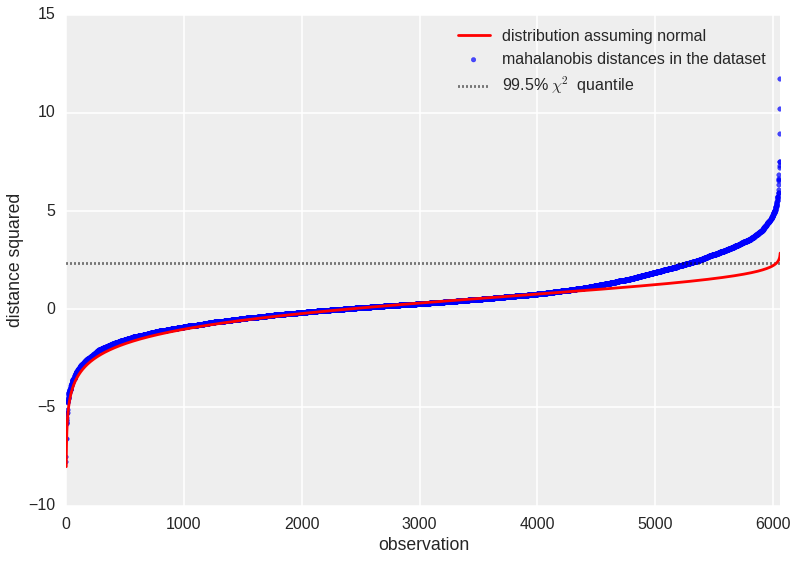

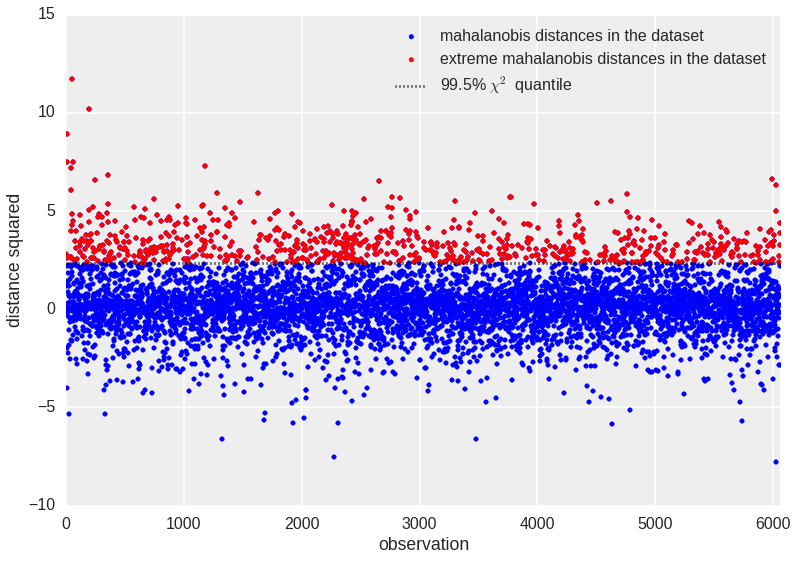

In [14]:
train_data=np.c_[train_total_price,train_reise_dauer]
outliers = Outlier_detection(support_fraction = 0.9999).fit(train_data)
outliers.plot(log=True,sort=True)
outliers.plot(log=True,sort=False)

So, we found that 0.120 of the test dataset could be removed because of the outliers. It were the true if we have had
'simplified' model *total_price ~ reise_dauer*. Indexes of the samples to be removed are:

In [15]:
# cleaning the dataset: remove all outliers of our 'simplified' model
condition_to_leave_data=(-outliers.iextreme_values)*(df.dataset.index.values+1) !=0
condition_to_remove_data=(outliers.iextreme_values)*(df.dataset.index.values+1) !=0


print 'The sample size before cleaning:  %.3f'% df.dataset.index.values.shape[0]
print 'The sample size after cleaning:  %.3f'% np.extract(condition_to_leave_data,df.dataset.index.values).shape[0]
print 'relative size of the removed piece: %.3f'%( np.extract(condition_to_remove_data,df.dataset.index.values).shape[0]/df.dataset.index.values.shape[0])
print 'indexes to be removed', np.extract(condition_to_remove_data,df.dataset.index)

The sample size before cleaning:  6064.000
The sample size after cleaning:  5318.000
relative size of the removed piece: 0.123
indexes to be removed [   0    3    5    9   32   38   39   41   43   45   47   49   50   57   58
   65   74   82   84   90  117  119  120  121  124  131  143  153  154  162
  168  177  180  185  190  194  197  200  210  213  214  215  218  226  228
  234  237  244  247  258  273  274  278  280  284  287  305  307  317  320
  325  328  346  350  351  353  355  356  365  367  369  374  375  381  406
  412  417  420  433  445  455  457  473  484  487  490  497  498  511  514
  519  523  537  573  579  586  588  589  619  624  630  633  641  642  652
  653  657  659  668  670  677  678  695  696  698  712  713  721  722  732
  738  741  743  748  749  764  773  774  800  802  805  807  820  824  830
  831  842  844  846  855  856  858  870  872  875  882  883  898  903  905
  915  919  922  939  947  952  960  984 1004 1017 1019 1020 1022 1028 1029
 1036 1037 1038

If we were increasing the complexity of the model, the problem with outlier could decrease:
thus for such model

$$ total\_price \sim age + reise\_dauer + no\_of\_persons + stars $$

only 9.3% of the dataset could be outliers (less than 12% in the *simplified* case).

0.089 proportion of outliers at 0.995% chi2 percentile, 
with support fraction 1.00.


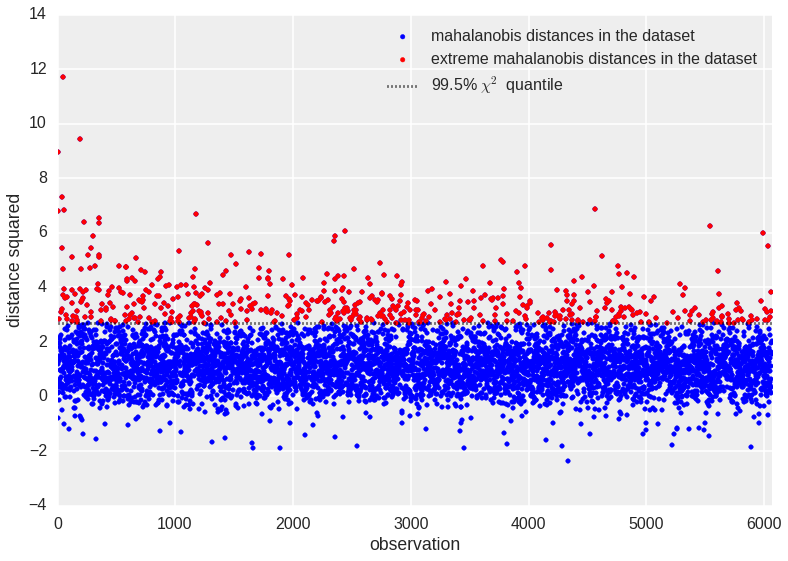

In [16]:
# we do not include target into outliers detection!
train_data = df.dataset[['age','reise_dauer','no_of_persons','stars']].as_matrix()


outliers = Outlier_detection(support_fraction = 0.9999).fit(train_data)
outliers.plot(log=True,sort=False)

### total_price  ~ age

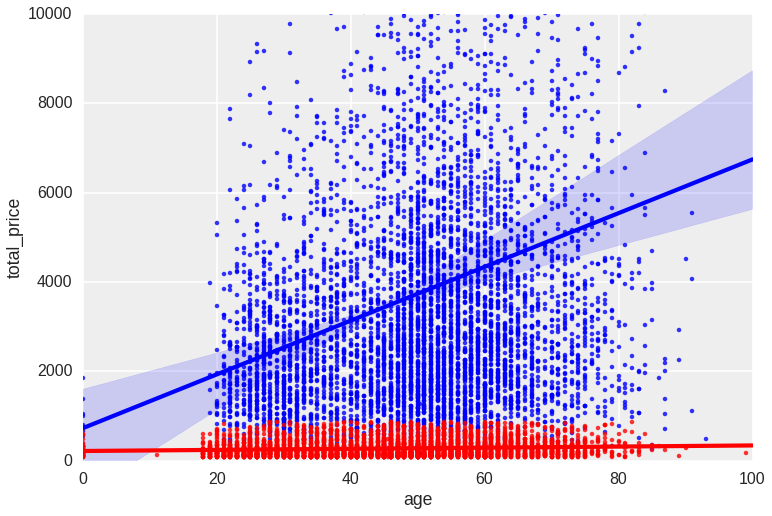

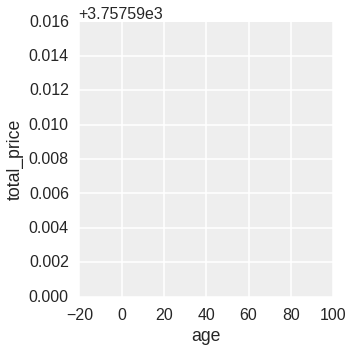

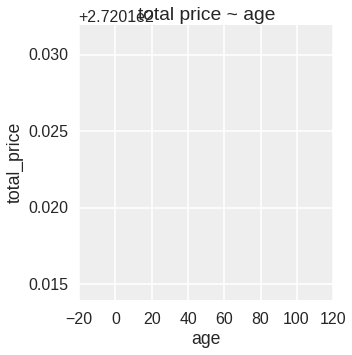

In [17]:
# total_price  ~ age
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))


np.random.seed(9221999)
sns.lmplot('age','total_price',df.dataset,ax=axes,color='b',label='train')
sns.lmplot('age','total_price',df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:],color='r',ax=axes,label='test')

axes.set_ylim(0,10000) #set limits on total_price:(0€,10Ki€)
axes.set_xlim(0,100) # set limits on age:(0,100 years)

plt.title('total price ~ age')
plt.savefig(plots_dir+prefix+'total_price_age'+'.png')


We can replot the previous figure in much more nicer style ... Also we can use higher
orders in the fit of data, here we use the order=2.

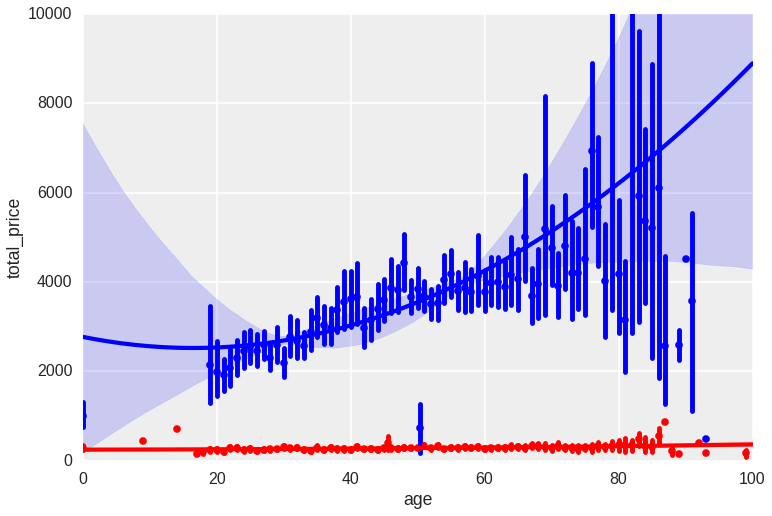

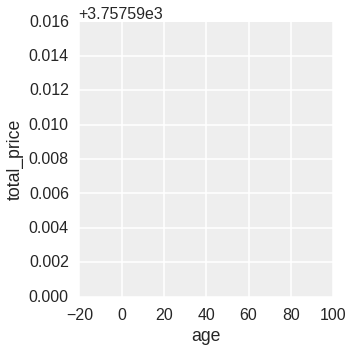

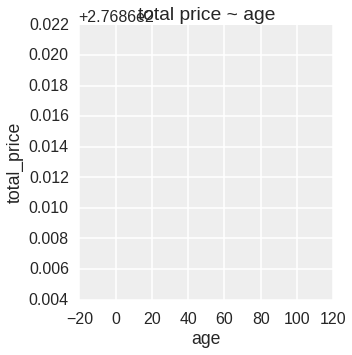

In [18]:
# total price ~ age
# much nicer plot
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))



axes.set_ylim(0,10000) #set limits on total_price:(0€,10Ki€)
axes.set_xlim(0,100) # set limits on age:(0,100 years)



sns.lmplot('age','total_price',df.dataset,ax=axes,color='b',label='train',x_estimator=mean,order=2)
sns.lmplot('age','total_price',df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:],color='r',ax=axes,label='test',x_estimator=mean,order=2)


plt.title('total price ~ age')
plt.savefig(plots_dir+prefix+'total_price_age_v2'+'.png')


### total_price  ~ no_of_persons

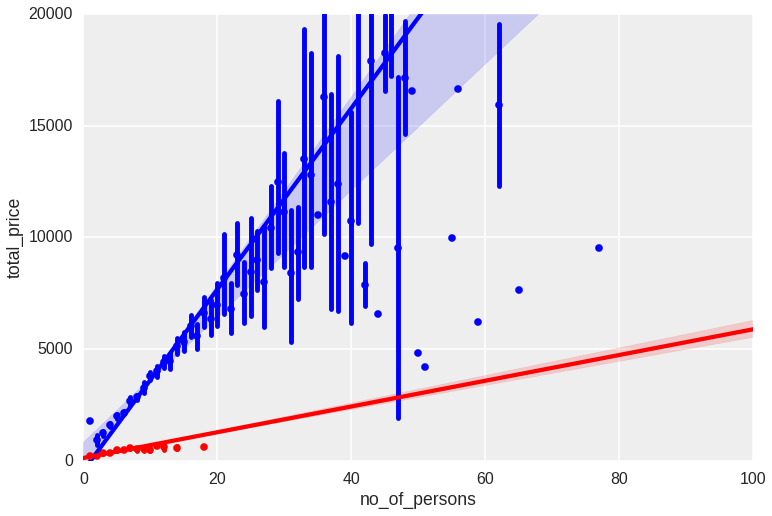

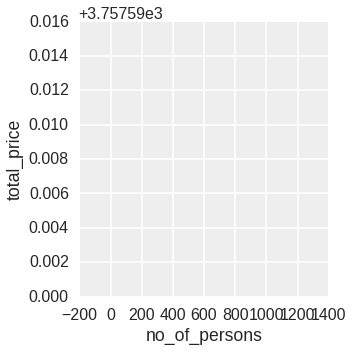

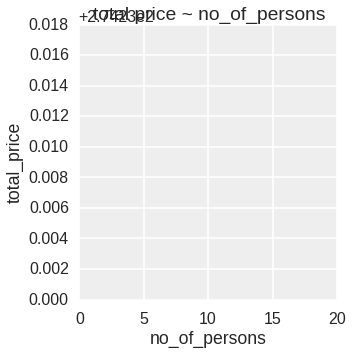

In [19]:
# total_price  ~ no_of_persons
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))

sns.lmplot('no_of_persons','total_price',df.dataset,ax=axes,color='b',label='train',x_estimator=mean)
sns.lmplot('no_of_persons','total_price',df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:],color='r',ax=axes,label='test',x_estimator=mean)

axes.set_ylim(0,20000) #set limits on total_price:(0€,20Ki€)
axes.set_xlim(0,100) # set limits on number of persons:(0,100)

plt.title('total price ~ no_of_persons')
plt.savefig(plots_dir+prefix+'total_price_no_of_persons'+'.png')


### total_price  ~ stars

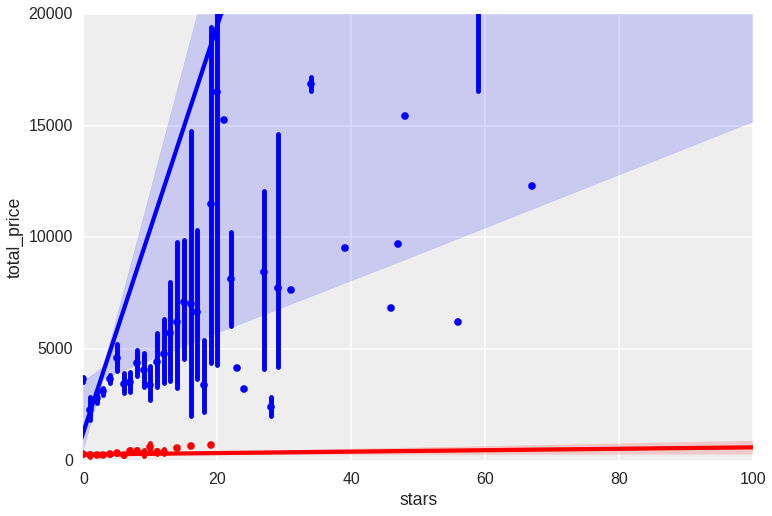

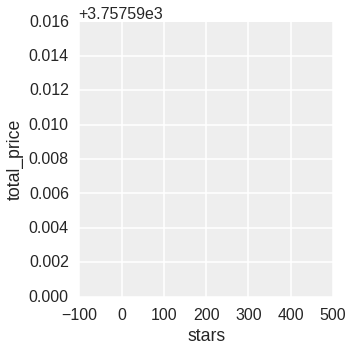

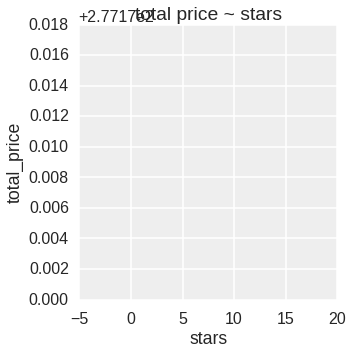

In [20]:
# total_price  ~ no_of_persons
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))

sns.lmplot('stars','total_price',df.dataset,ax=axes,color='b',label='train',x_estimator=mean)
sns.lmplot('stars','total_price',df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:],color='r',ax=axes,label='test',x_estimator=mean)

axes.set_ylim(0,20000) #set limits on total_price:(0€,20Ki€)
axes.set_xlim(0,100) # set limits on number of stars:(0,100)

plt.title('total price ~ stars')
plt.savefig(plots_dir+prefix+'total_price_stars'+'.png')


### Correlation Maxtrix
-----------------------------

It's time to get correlation among features and target. First, we do for test dataset

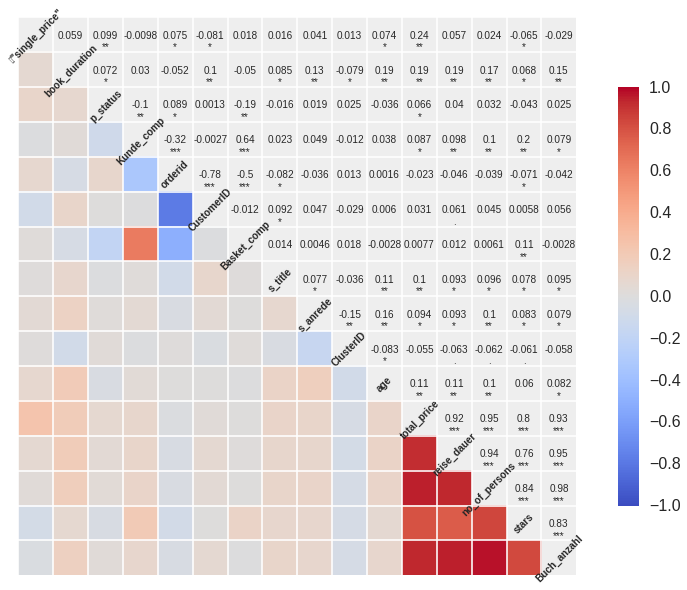

In [21]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(15, 10))

sns.corrplot(df.dataset, ax=axes);


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


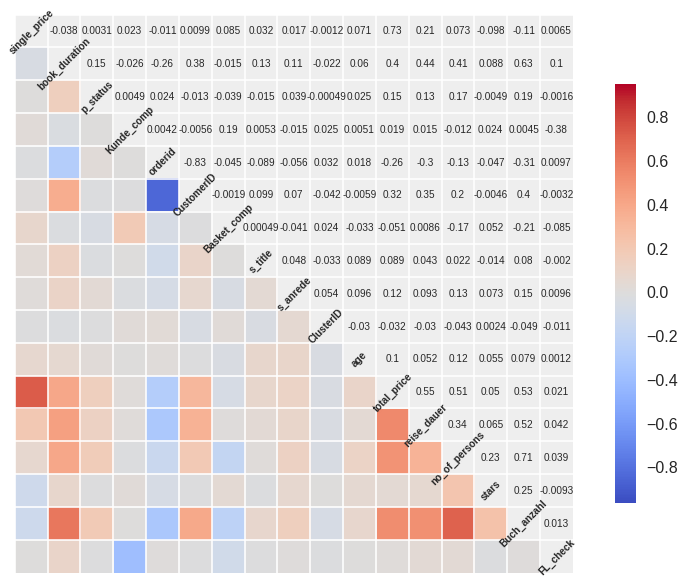

In [22]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(15, 10))

sns.corrplot(df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:], ax=axes);


So. Let's summarize the *train* dataset

* total_price is the best correlated with 
        reise_dauer, no_of_persons, stars, Buch_anzahl, book_duration,s_anrede,age and single_price

* 
        reise_dauer, no_of_persons, stars, Buch_anzahl 
    are highly correlated among themselves

Let's summarize the *test* dataset

* total_price is the best correlated with single_price, reise_dauer and no_of_persons


What features are we going to include in the model of the best customer of 2015? 

Well, as we want to use *train* dataset for this purpose, we need to include high-correlated 

    reise_dauer, no_of_persons, stars, Buch_anzahl, book_duration    

features. But because of their self-correlations, we are in dangerous situation: overfitting problem increases, when
our model is subject of statisical fluctuations among distributions of the features.


How are we going to solve the problem of the overfitting? I propose a three-step procedure:

1. removing outliers and a check correlations afterwards
2. try to use L1 penalty term in the Linear Model 
3. If step two, doesn't show significant improvement, try to remove from the model such features that are presented
in the *test* model.

What is the *test* model? So, in paralell, we model 'total_price' using *test* data and call this model the *test* model.


For this regression, because we don't have data on customers who did not book anything after getting the mail with
'Gutscheine'. Logistic or Multinomial or Ordered-probit models  are not possible without additional transformations. We can only consider two types of the model: 


* a simple linear model (aka Ordinary Least Squares or OLS) with  a linear predictor
* a generelized linear model with Gaussian family, were we assume the 
        total_price~Norm(book_duration+reise_dauer + age + s_anrede+ no_of_persons + stars + Buch_anzahl+intercept,Cov) + noise




### A  Ordinary Least Squares 
------------------------------------

We can make a very rude model, immediatelly, i.e ad-hoc modelling will be 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     8159.
Date:                Tue, 26 May 2015   Prob (F-statistic):               0.00
Time:                        14:34:27   Log-Likelihood:                -55942.
No. Observations:                6064   AIC:                         1.119e+05
Df Residuals:                    6056   BIC:                         1.120e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -704.6534    123.779     -5.693      0.000      -947.304  -462.003
book_duration     0.3228      0.060      5.399      0.000         0.206     0.440
age               3.1169      2.286      1.364      0.173        -1.364     7.598
s_anrede        -74.2916     47.205     -1.574      0.116      -166.830    18.247
reise_dauer      30.5331      1.483     20.583      0.000        27.625    33.441
no_of_persons   288.8923      8.424     34.295      0.000       272.379   305.406
stars            50.0778      8.560      5.850      0.000        33.297    66.858
Buch_anzahl     -12.5995     13.256     -0.950      0.342       -38.587    13.388
==============================================================================
Omnibus:                     5634.340   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6895499.151
Skew:                          -3.319   Prob(JB):                         0.00
Kurtosis:                     168.066   Cond. No.                     4.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

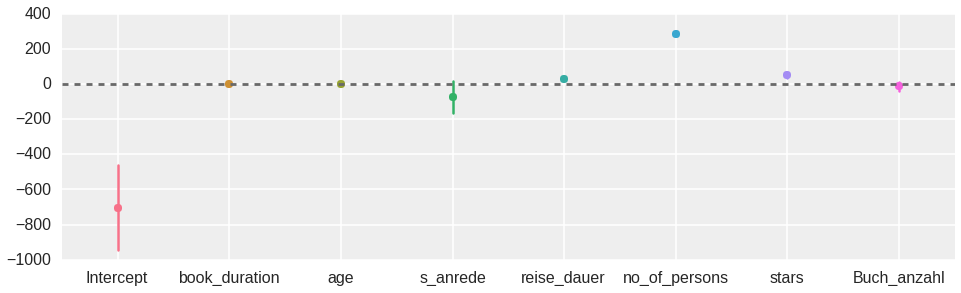

In [8]:
import statsmodels.api as sm
sns.coefplot("total_price ~  book_duration + age +s_anrede+ reise_dauer + no_of_persons + stars + Buch_anzahl", df.dataset, ci=95,intercept=True) # 95%CL for errors on coefficients 
model=sm.OLS.from_formula("total_price ~book_duration  + age +  s_anrede +reise_dauer + no_of_persons + stars + Buch_anzahl",  df.dataset)
model.fit(q=0.95).summary()



Can we improve performance of OLS, i.e increase $R^2$ and decrease the errors on estimated parameters?
Let's try a set of optimizations:

1. transform data to standard represanation (i.e remove mean() and devide it by std() )
2. remove outliers
3. add some non-numerical values (aka categories)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     8159.
Date:                Fri, 22 May 2015   Prob (F-statistic):               0.00
Time:                        14:37:13   Log-Likelihood:                -55942.
No. Observations:                6064   AIC:                         1.119e+05
Df Residuals:                    6056   BIC:                         1.120e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             3757.5987     31.563    119.052      0.000      3695.725  3819.473
scale(book_duration)   179.4638     33.238      5.399      0.000       114.305   244.623
scale(age)              44.5801     32.692      1.364      0.173       -19.507   108.668
scale(s_anrede)        -50.9303     32.361     -1.574      0.116      -114.369    12.509
scale(reise_dauer)    2134.9279    103.724     20.583      0.000      1931.593  2338.263
scale(no_of_persons)  5342.7274    155.788     34.295      0.000      5037.327  5648.128
scale(stars)           348.1699     59.514      5.850      0.000       231.502   464.838
scale(Buch_anzahl)    -162.1977    170.654     -0.950      0.342      -496.740   172.345
==============================================================================
Omnibus:                     5634.340   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6895499.151
Skew:                          -3.319   Prob(JB):                         0.00
Kurtosis:                     168.066   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

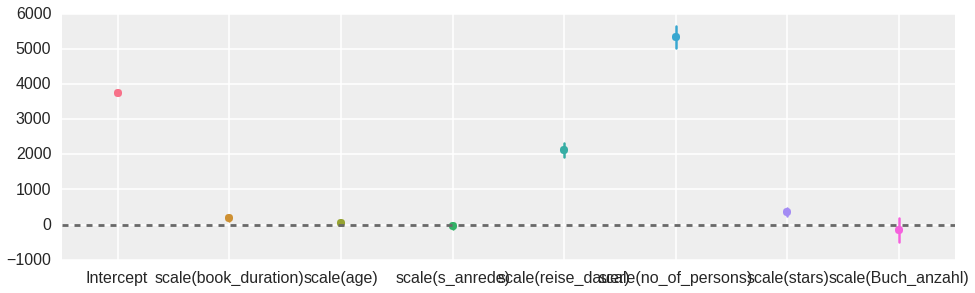

In [28]:
# 1. transform data to standard represanation (i.e remove mean() and devide by std() )

import statsmodels.api as sm
sns.coefplot("total_price ~ scale(book_duration) + scale(age) +scale(s_anrede)+  +  scale(reise_dauer) + scale(no_of_persons) + scale(stars) + scale(Buch_anzahl)", df.dataset, ci=95,intercept=True) # 95%CL for errors on coefficients 
model=sm.OLS.from_formula("total_price ~ scale(book_duration)+ scale(age) +scale(s_anrede) + scale(reise_dauer) + scale(no_of_persons) + scale(stars) + scale(Buch_anzahl)",  df.dataset)
model.fit(q=0.95).summary()



It does not helps much. (:-

0.117 proportion of outliers at 0.995% chi2 percentile, 
with support fraction 0.99.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     904.9
Date:                Fri, 22 May 2015   Prob (F-statistic):               0.00
Time:                        14:38:01   Log-Likelihood:                -46782.
No. Observations:                5354   AIC:                         9.358e+04
Df Residuals:                    5346   BIC:                         9.363e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             3103.7105     20.629    150.455      0.000      3063.270  3144.151
scale(book_duration)    64.2675     23.065      2.786      0.005        19.052   109.483
scale(age)              22.8432     21.253      1.075      0.283       -18.822    64.508
scale(s_anrede)         25.8954     21.155      1.224      0.221       -15.577    67.368
scale(reise_dauer)    1335.5644     29.406     45.418      0.000      1277.917  1393.212
scale(no_of_persons)   975.4542     33.182     29.398      0.000       910.405  1040.504
scale(stars)           -97.4569     21.509     -4.531      0.000      -139.624   -55.290
scale(Buch_anzahl)    -567.8807     39.142    -14.508      0.000      -644.614  -491.147
==============================================================================
Omnibus:                     2893.643   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63459.652
Skew:                           2.115   Prob(JB):                         0.00
Kurtosis:                      19.327   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

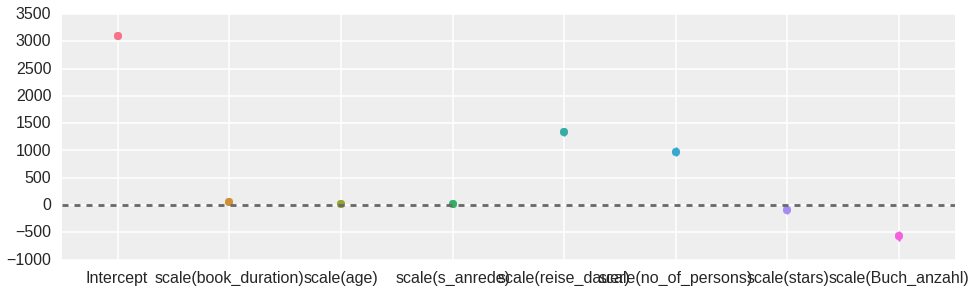

In [29]:
# 2. remove outliers
train_data = df.dataset[['age','reise_dauer','s_anrede','no_of_persons','stars','Buch_anzahl','book_duration']].as_matrix()
outliers = Outlier_detection(support_fraction = 0.995,chi2_percentile =0.995).fit(train_data)

condition_to_leave_data=(-outliers.iextreme_values)*(df.dataset.index.values+1) !=0
condition_to_remove_data=(outliers.iextreme_values)*(df.dataset.index.values+1) !=0

cleaned_train_data = df.dataset.loc[np.extract(condition_to_leave_data,df.dataset.index),:] 

import statsmodels.api as sm
sns.coefplot("total_price ~ scale(book_duration)+ scale(age) + scale(s_anrede) +scale(reise_dauer) + scale(no_of_persons) + scale(stars) + scale(Buch_anzahl)", cleaned_train_data, ci=95,intercept=True) # 95%CL for errors on coefficients 
model=sm.OLS.from_formula("total_price ~ scale(book_duration) + scale(age) + scale(s_anrede) + scale(reise_dauer) + scale(no_of_persons) + scale(stars) + scale(Buch_anzahl)",  cleaned_train_data)
model.fit(q=0.95).summary()



As expected the $R^2$ has downgraded (because of the removing large contributors to the fit), but the errors on coefficients has been improved. Let's add some categorials:

* p_status

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     295.1
Date:                Fri, 22 May 2015   Prob (F-statistic):               0.00
Time:                        14:39:30   Log-Likelihood:                -46741.
No. Observations:                5354   AIC:                         9.353e+04
Df Residuals:                    5331   BIC:                         9.368e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             -819.6390    260.749     -3.143      0.002     -1330.813  -308.465
C(p_status)[T.101]    -779.4495    790.456     -0.986      0.324     -2329.066   770.167
C(p_status)[T.110]   -1408.1511   1523.613     -0.924      0.355     -4395.056  1578.754
C(p_status)[T.111]     161.5597   1522.064      0.106      0.915     -2822.308  3145.428
C(p_status)[T.1100]    239.6366    261.718      0.916      0.360      -273.437   752.710
C(p_status)[T.1101]    -33.8397    273.157     -0.124      0.901      -569.340   501.660
C(p_status)[T.1110]    803.5928    559.417      1.436      0.151      -293.093  1900.279
C(p_status)[T.1111]    877.6691    790.261      1.111      0.267      -671.566  2426.904
C(p_status)[T.10100]   541.8255    249.426      2.172      0.030        52.848  1030.803
C(p_status)[T.10101]   370.8862    254.447      1.458      0.145      -127.934   869.706
C(p_status)[T.10110]   761.5680    275.747      2.762      0.006       220.991  1302.145
C(p_status)[T.10111]   318.7332    335.125      0.951      0.342      -338.249   975.715
C(p_status)[T.11100]   711.3240    256.202      2.776      0.006       209.063  1213.585
C(p_status)[T.11101]   231.8801    270.275      0.858      0.391      -297.969   761.729
C(p_status)[T.11110]   988.5629    346.715      2.851      0.004       308.860  1668.266
C(p_status)[T.11111]   625.8764    540.674      1.158      0.247      -434.066  1685.819
book_duration            0.1593      0.047      3.386      0.001         0.067     0.252
reise_dauer             96.5060      2.151     44.866      0.000        92.289   100.723
age                      2.2661      1.506      1.505      0.133        -0.687     5.219
s_anrede                38.4580     31.564      1.218      0.223       -23.420   100.336
no_of_persons          251.8247      8.846     28.467      0.000       234.483   269.167
stars                  -38.4687      8.580     -4.483      0.000       -55.290   -21.648
Buch_anzahl           -326.6416     25.121    -13.003      0.000      -375.889  -277.394
==============================================================================
Omnibus:                     2958.964   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66794.741
Skew:                           2.173   Prob(JB):                         0.00
Kurtosis:                      19.749   Cond. No.                     8.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

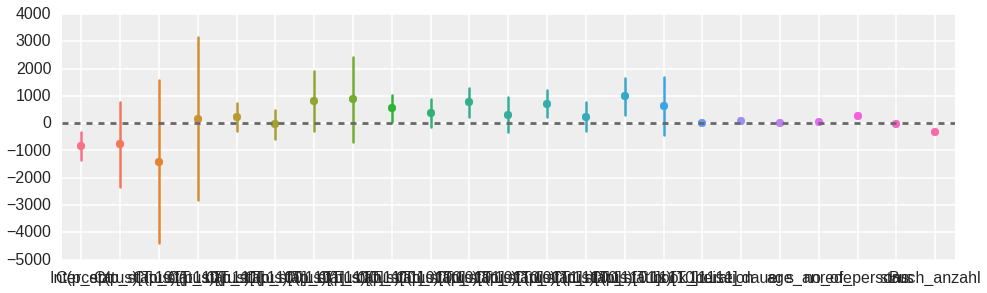

In [31]:
import statsmodels.api as sm
sns.coefplot("total_price ~ book_duration+reise_dauer + age + s_anrede + no_of_persons + stars + Buch_anzahl + C(p_status) ", cleaned_train_data, ci=95,intercept=True) # 95%CL for errors on coefficients 
model=sm.OLS.from_formula("total_price ~book_duration+reise_dauer + age + s_anrede + no_of_persons + stars + Buch_anzahl + C(p_status) ",  cleaned_train_data)
model.fit(q=0.95).summary()





Afterwards, $R^2$ is improved in 1%

### Generalized Linear Models
------------------------------------------


These models are MLE-based, where likelihoods are presented by the exponentional  probability. Depending on the nature (Normal, Bernoulli, Poisson etc distributions, called the family of the GLM) of the target, the appropriate link functions, functions those first derivative of the inverse  is fitted to the simple linear model using MLE.
This is a connection between GLM and the OLS.  

In order to go further, we need to make some assumptions:

our observable, $Y_i$, the `total_price` of the $i^{\text{th}}$ customer is a Normal distributed stochatistic
variable $Y$:

$$ P(Y|\eta) = \frac{1}{\sqrt{2\pi\sigma}}exp(\frac{-(Y-\eta)^2}{2\sigma}). $$
 
Here $\eta$ is a mean value of the `total_price` and it is a linear function of the $i^{\text{th}}$  customer features $X^j_i$:

$$ \eta_i = \sum_j \beta_jX^j_i. $$

Following from this prescription, we conclude that our GLM will use Gaussian family with an identity function to be the link function.


In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import family


def R2(y,fit_result):
    ''' calculates the R2 from GLM of the statsmodel '''
    
    sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
    sse_val = sum(map(lambda x: np.power(x,2),fit_result.resid_response))
    return 1.0 - sse_val/sst_val


model=GLM.from_formula("total_price ~book_duration+age + s_anrede +reise_dauer + no_of_persons + stars + Buch_anzahl", df.dataset,family=family.Gaussian())
result_GLM=model.fit(q=0.95)

# print summary on the fit
print result_GLM.summary()

# print R2 coefficient
print 'R2: %.3f'%R2(df.dataset['total_price'].as_matrix(),result_GLM)


                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_price   No. Observations:                 6064
Model:                            GLM   Df Residuals:                     6056
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                   6040985.16406
Method:                          IRLS   Log-Likelihood:                -55942.
Date:                Fri, 22 May 2015   Deviance:                   3.6584e+10
Time:                        14:40:31   Pearson chi2:                 3.66e+10
No. Iterations:                     4                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -704.6534    123.779     -5.693      0.000      -947.255  -462.051
book_duration     0.3228      0.060      5.

The result is identical to the OLS! :-)

###Rgression Graphics

------------------------


The last thing which remains to be answered before closing the topic on Linear Regression is visualization of the 
linear models. We make so-called `regression plots`. We consider:

* influence plots 
* partial Regression Plots

Influence plots show the (externally) studentized residuals vs. the leverage of each observation as measured by the hat matrix.

Externally studentized residuals are residuals that are scaled by their standard deviation where 

$$var(\hat{\epsilon}_i)=\hat{\sigma}^2_i(1-h_{ii})$$

with

$$\hat{\sigma}^2_i=\frac{1}{n - p - 1 \;\;}\sum_{j}^{n}\;\;\;\forall \;\;\; j \neq i$$

$n$ is the number of observations and $p$ is the number of regressors. $h_{ii}$ is the $i$-th diagonal element of the hat matrix

$$H=X(X^{\;\prime}X)^{-1}X^{\;\prime}$$

The influence of each point can be visualized by the criterion keyword argument. Options are Cook's distance and DFFITS, two measures of influence.


Since we are doing multivariate regressions, we cannot just look at individual bivariate plots to discern relationships.
Instead, we want to look at the relationship of the dependent variable and independent variables conditional on the other
independent variables. We can do this through using partial regression plots, otherwise known as added variable plots. 

#### Influence plots


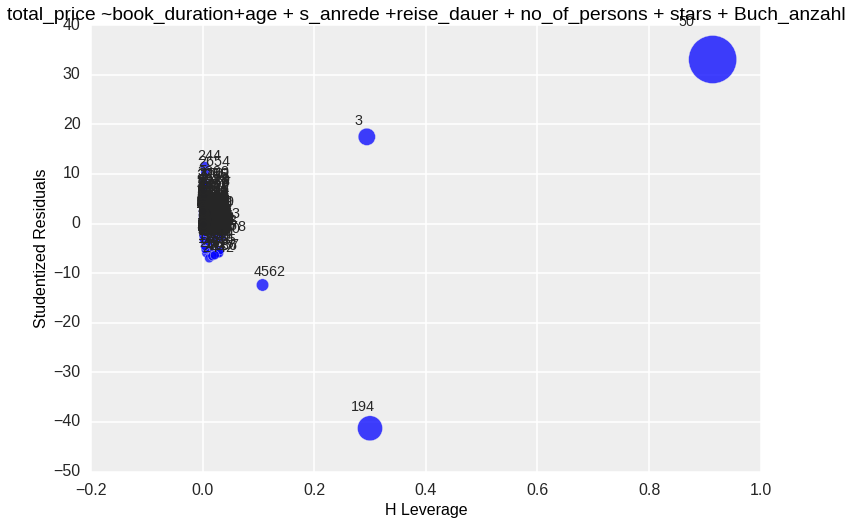

In [9]:
from statsmodels.formula.api import ols
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))



model=ols("total_price ~book_duration+age + s_anrede +reise_dauer + no_of_persons + stars + Buch_anzahl",  df.dataset)
result=model.fit()
fig = sm.graphics.influence_plot(result, ax=axes, criterion="cooks")



plt.title('total_price ~book_duration+age + s_anrede +reise_dauer + no_of_persons + stars + Buch_anzahl')
plt.savefig(plots_dir+prefix+'influence_plot_GLM'+'.png')



This plots shows `t-student` residuals vs `H-distance` ( the Covariance distance ). The samples numbers (indexes in the dataset) are given as well. We see that the largest distance is for the index 50. This is our outlier.
It has also the largest `t-student` residual, meaning that it's target is far away from predicted value.
We can get a list of outliers using the approach below:


In [10]:
residuals=result.get_influence().summary_frame()

In [11]:
# print indexes of outliers  
print df.dataset.loc[
    (residuals['hat_diag']>0.15) |  
    (abs(residuals['student_resid']>4)) ].index


#residuals['cooks_d'].describe()

Int64Index([3, 50, 194, 244, 417, 743, 952, 1219, 1351, 1772, 2259, 2465, 2529, 2654, 2765, 2838, 2972, 3300, 3891, 4347, 4503, 4761, 5384, 6028], dtype='int64')


However, only two outlier has a large influence on the result:

In [12]:
# print indexes of outliers  
outliers_indexes= df.dataset.loc[
    (residuals['hat_diag']>0.15) &
    
    (abs(residuals['student_resid']>4)) ].index

print outliers_indexes


Int64Index([3, 50], dtype='int64')


#### Partial Regression Plots
-----------------------------

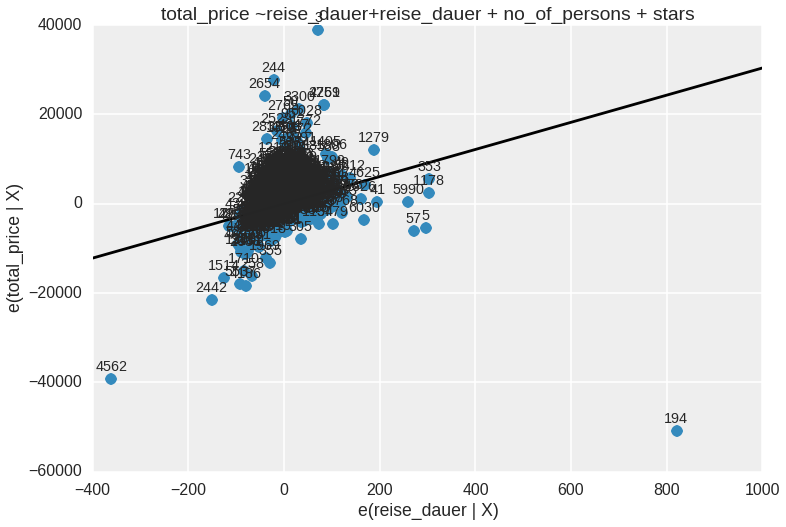

In [41]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))


# let's plot  the partial effect from  'reise_dauer' regression on 'total_price' among 3 features: "no_of_persons",  "stars","reise_dauer"
fig = sm.graphics.plot_partregress("total_price", "reise_dauer", ["no_of_persons",'stars'], data=df.dataset, ax=axes)




plt.title('total_price ~reise_dauer+reise_dauer + no_of_persons + stars ')
plt.savefig(plots_dir+prefix+'GLM_partial_reise_dauer'+'.png')

So we see here: 

impact of the exlcuding `reise_dauer` in each sample on the expected (mean) value of the `total_price`.
So if we see large positive $E(Y|X)$ values (Y=total_price, X=reise_dauer), this corresponds that other variables presented ("no_of_persons",'stars') gives very positive effect. Also non-zero values of $E(X|\tilde{X})$ values ($X$=reise_dauer,$\tilde{X}=$["no_of_persons",'stars']), provides a hint on influence of the $\tilde{X}$ on $X$.

Main conclusions here are:

* we see positive dependence of `total_price` on `reise_dauer`
* we see positive dependence of `reise_dauer` on `stars` + `no_of_persons`

Another plot shows standalone contribution of `stars` component.

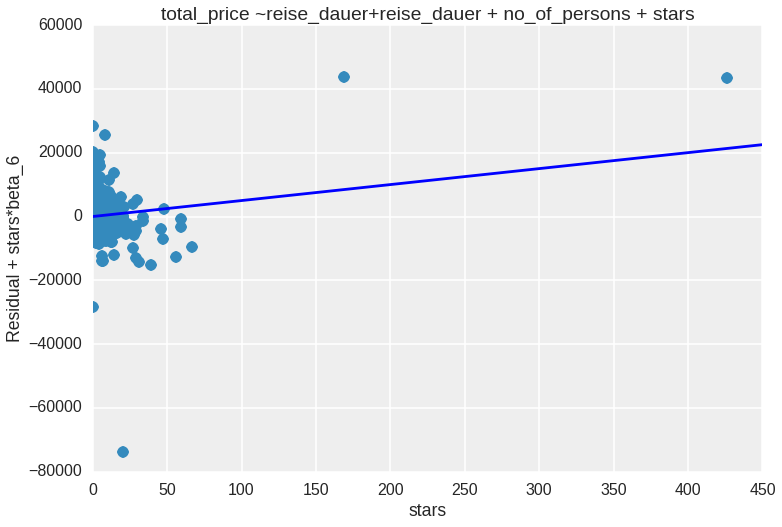

In [42]:
sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))


# let's plot  the partial effect from  'stars' 
fig = sm.graphics.plot_ccpr(result, "stars", ax=axes)



plt.title('total_price ~reise_dauer+reise_dauer + no_of_persons + stars ')
plt.savefig(plots_dir+prefix+'GLM_partial_stars_v2'+'.png')



And we want to make a summary plot (here the cleaned dataset will be used):

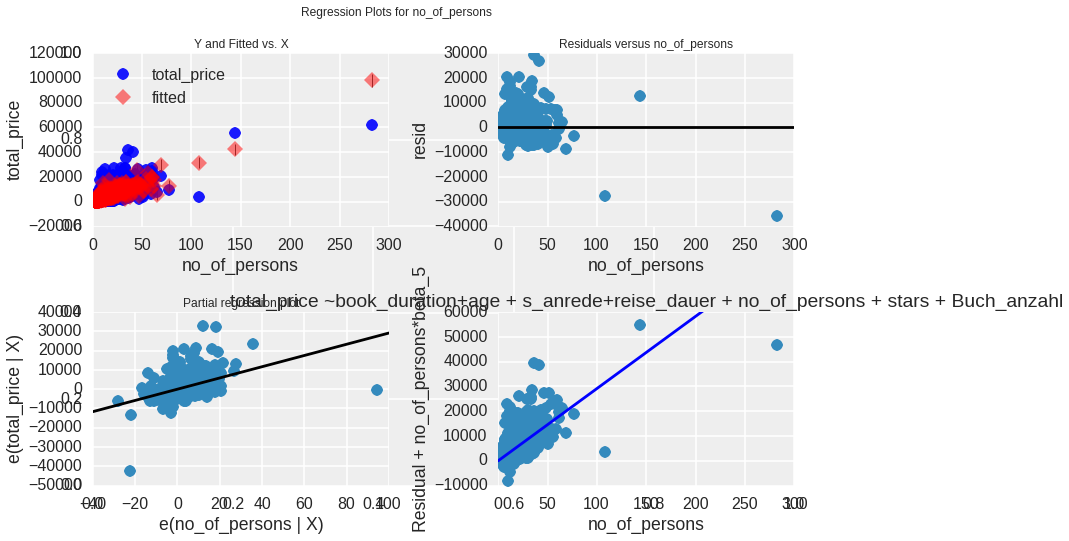

In [68]:
# try to compare the cleaned from outliers dataset (10% of outliers was removed) 1)
# and naively cleaned  dataset: removing only the largest outlier (index 8) 2)

# 1) 
#model=ols("total_price ~book_duration+reise_dauer + no_of_persons + stars + Buch_anzahl",  cleaned_train_data)

# 2) 
model=ols("total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl",  df.dataset.loc[np.delete(df.dataset.index.values,outliers_indexes.values),:])
result=model.fit()


sns.set_context("poster")
f, axes = pl.subplots(figsize=(12, 8))


# let's plot  the partial effect from  'stars' 
fig = sm.graphics.plot_regress_exog(result, "no_of_persons", fig=f)
ax =fig.get_axes()[1]
ax.get_lines()[1].set_alpha(0.5)

plt.title('total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl')
plt.savefig(plots_dir+prefix+'GLM_summary_no_of_persons'+'.png')





We can plot only first figure from the grid above:

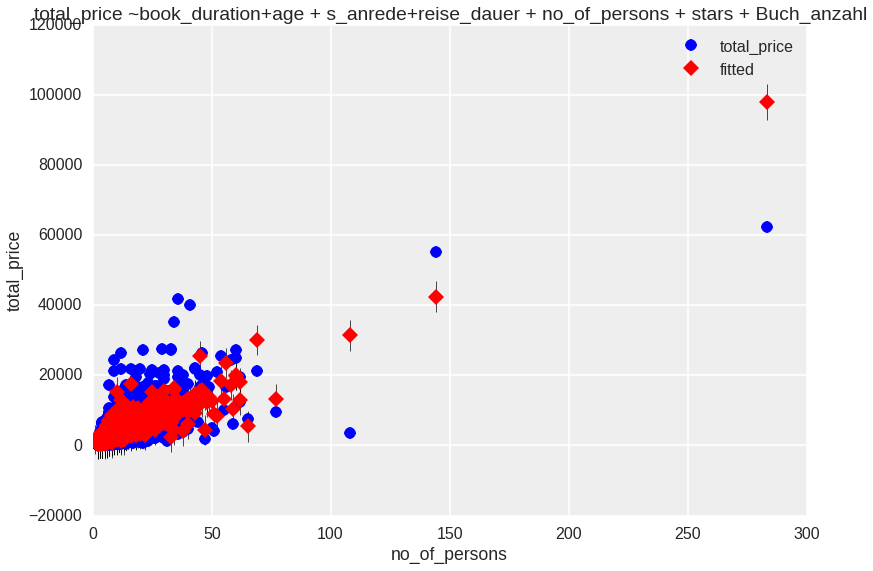

In [69]:
sns.set_context("poster")
#plt.subplots(1,figsize=(12, 8))


sm.graphics.plot_fit(result, "no_of_persons")


plt.title('total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl')
plt.savefig(plots_dir+prefix+'GLM_fit_no_of_persons_v2'+'.png')



Let's compare predicted total_price with a total_price in the train dataset:

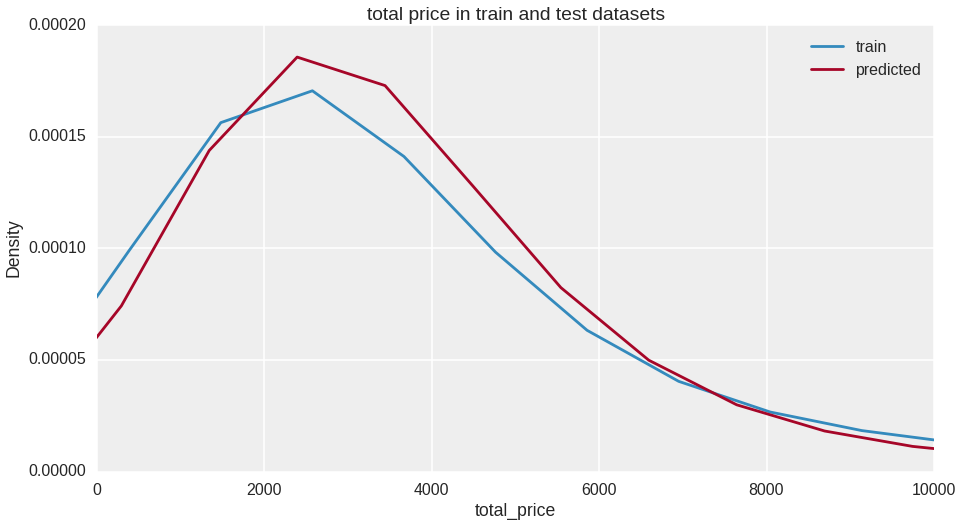

In [13]:
sns.set_context("poster")
plt.figure(figsize=(15,8))

train_price =df.dataset['total_price']

model = sm.OLS.from_formula("total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl",  df.dataset.loc[df.dataset.index != 8,:])

result=model.fit()
X=df.dataset[['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age','s_anrede']]
df.dataset['pred_total_price'] = result.predict(X)

pred_price=df.dataset['pred_total_price']

train_price.plot(kind='kde',xlim=(0,10000),legend=True,label='train')
pred_price.plot(kind='kde',xlim=(0,10000),legend=True,label='predicted')
pl.xlabel('total_price')
pl.title('total price in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'predicted_total_price'+'.png')

This is a predicted total_price and  a total_price in the cleaned train dataset using different options of the cleaning:

* option_1 -> remove the two largest outlier (train_1,predicted_1 plots)
* option_2 -> remove the outliers using Chi2 distribution (train_2,predicted_2 plots)


In [14]:
sns.set_context("poster")
plt.figure(figsize=(15,8))


# compare results of the cleaning 
# 1) use  df.dataset.loc[df.dataset.index != 8,:])
# 2) use cleaned_train_data

train_price_1=df.dataset.loc[np.delete(df.dataset.index.values,outliers_indexes.values),:]['total_price']
model_1 = sm.OLS.from_formula("total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl", df.dataset.loc[df.dataset.index != 8,:])

train_price_2 =cleaned_train_data['total_price']
model_2 = sm.OLS.from_formula("total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl",  cleaned_train_data)


result1=model_1.fit()
result2=model_2.fit()
X=df.dataset[['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age','s_anrede']]
df.dataset['pred_total_price1'] = result1.predict(X)
df.dataset['pred_total_price2'] = result2.predict(X)

pred_price_1=df.dataset['pred_total_price1']
pred_price_2=df.dataset['pred_total_price2']

train_price_1.plot(kind='kde',xlim=(0,10000),legend=True,label='train_1')
pred_price_1.plot(kind='kde',xlim=(0,10000),legend=True,label='predicted_1')
train_price_2.plot(kind='kde',xlim=(0,10000),legend=True,label='train_2')
pred_price_2.plot(kind='kde',xlim=(0,10000),legend=True,label='predicted_2')

pl.xlabel('total_price')
pl.title('total price in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'predicted_total_price_v2'+'.png')

NameError: name 'cleaned_train_data' is not defined

Definitely, the outliers play a significant role in the analysis.

### The  L1 penalty term in the Linear Model 
-----------------------------

Next we fit a sequence of models using the lasso. We collect the parameter estimates and display them as a table. This is a crude way to obtain the "solution path". 

In [73]:
# formula
fml = "total_price ~book_duration+age + s_anrede+reise_dauer + no_of_persons + stars + Buch_anzahl"


# compare results of the cleaning 
# 1) use  df.dataset.loc[df.dataset.index != 8,:]
#data = df.dataset.loc[df.dataset.index != 8,:]
# 2) use cleaned_train_data
data = cleaned_train_data
# 3) uncleaned data
#data = df.dataset
mat = []




alphas = np.arange(0, 1e4, 1e3) # L1 penalty
for alpha in alphas:
    mod = sm.OLS.from_formula(fml, data)
    rslt = mod.fit_regularized(alpha=alpha,disp=False) 
    mat.append(rslt.params.append(pd.Series({'R2':rslt.summary().tables[0][0][3]}))) # add R2 score
mat = pd.DataFrame(mat, index=[str(x) for x in alphas])
mat.T



0.0     1000.0     2000.0    3000.0     4000.0  \
Intercept      -266.8023          0          0         0          0   
book_duration  0.1307255  0.1905697  0.4258143  0.553571  0.6703677   
age             1.611906          0   3.962139  3.957299   3.500951   
s_anrede        38.81138          0          0         0          0   
reise_dauer     96.75478   89.46845   96.40242  93.13456   88.78692   
no_of_persons   253.2259   80.36985   7.118381         0          0   
stars          -38.20264          0          0         0          0   
Buch_anzahl    -333.6047          0          0         0          0   
R2                 0.542      0.503      0.466     0.457      0.450   

                  5000.0     6000.0    7000.0    8000.0    9000.0  
Intercept              0          0         0         0         0  
book_duration  0.7871644  0.9039612  1.020758  1.137555  1.254351  
age             3.044602   2.588254  2.131905  1.675557  1.219209  
s_anrede               0          0         0         0         0  
reise_dauer     84.43928   80.09165  75.74401  71.39637  67.04873  
no_of_persons          0          0         0         0         0  
stars                  0          0         0         0         0  
Buch_anzahl            0          0         0         0         0  
R2                 0.441      0.431     0.419     0.405     0.389

###Linear Model of the order = 2 (aka Polynomial Model of the order=2)
----------------

In [74]:
features  = ['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age','s_anrede']

#data = df.dataset.loc[df.dataset.index != 8,:]
data = cleaned_train_data
fml = "total_price ~ "
# normalization of the data
for vname in features:
    data[vname] = (data[vname] - data[vname].mean()) / data[vname].std()
    fml+=vname+" + "


for j1,v1 in enumerate(features):
    x = data[v1] * data[v1]
    x = (x - x.mean()) / x.std()
    data[v1 + "_x_" + v1] = x
    fml+=v1 + "_x_" + v1+" + "
    for j2,v2 in enumerate(features[0:j1]):
        x = data[v1] * data[v2]
        x = (x - x.mean()) / x.std()
        data[v1 + "_x_" + v2] = x
        fml+=v1 + "_x_" + v2+" + "

fml = fml[:-2] # remove last '+'

mod_poly_2 = sm.OLS.from_formula(fml, data)
rslt_2 = mod_poly_2.fit()
rslt_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     199.8
Date:                Fri, 22 May 2015   Prob (F-statistic):               0.00
Time:                        14:59:02   Log-Likelihood:                -46627.
No. Observations:                5354   AIC:                         9.333e+04
Df Residuals:                    5318   BIC:                         9.356e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                      3103.7105     20.094    154.457      0.000      3064.317  3143.104
book_duration                    36.8831     25.486      1.447      0.148       -13.080    86.847
reise_dauer                    1449.1721     36.784     39.397      0.000      1377.061  1521.283
no_of_persons                  1035.3661     39.088     26.488      0.000       958.737  1111.995
stars                          -106.6771     26.276     -4.060      0.000      -158.189   -55.165
Buch_anzahl                    -654.0373     46.011    -14.215      0.000      -744.238  -563.837
age                              42.1127     21.255      1.981      0.048         0.444    83.782
s_anrede                         12.0447     21.023      0.573      0.567       -29.168    53.258
book_duration_x_book_duration    15.8601     27.741      0.572      0.568       -38.523    70.244
reise_dauer_x_reise_dauer      -287.6908     47.356     -6.075      0.000      -380.527  -194.854
reise_dauer_x_book_duration     -57.4436     35.873     -1.601      0.109      -127.770    12.883
no_of_persons_x_no_of_persons  -198.9785     51.225     -3.884      0.000      -299.400   -98.557
no_of_persons_x_book_duration    -4.4343     38.608     -0.115      0.909       -80.122    71.254
no_of_persons_x_reise_dauer     693.0752     52.589     13.179      0.000       589.979   796.172
stars_x_stars                    61.4781     28.641      2.147      0.032         5.330   117.626
stars_x_book_duration            17.5583     23.649      0.742      0.458       -28.804    63.921
stars_x_reise_dauer              92.5769     29.110      3.180      0.001        35.509   149.645
stars_x_no_of_persons           -50.2325     35.862     -1.401      0.161      -120.536    20.071
Buch_anzahl_x_Buch_anzahl       235.2197     72.396      3.249      0.001        93.294   377.145
Buch_anzahl_x_book_duration      75.0691     47.680      1.574      0.115       -18.404   168.542
Buch_anzahl_x_reise_dauer      -293.2933     72.786     -4.030      0.000      -435.984  -150.603
Buch_anzahl_x_no_of_persons    -216.2607     83.845     -2.579      0.010      -380.631   -51.890
Buch_anzahl_x_stars             -75.4476     42.267     -1.785      0.074      -158.308     7.413
age_x_age                       -46.5215     21.386     -2.175      0.030       -88.447    -4.596
age_x_book_duration             -11.0696     23.810     -0.465      0.642       -57.747    35.608
age_x_reise_dauer                77.4076     30.357      2.550      0.011        17.896   136.920
age_x_no_of_persons              44.6814     34.648      1.290      0.197       -23.243   112.606
age_x_stars                      -1.2671     21.554     -0.059      0.953       -43.522    40.988
age_x_Buch_anzahl               -85.5627     

Check the influence of the L1 penalty term

In [75]:
mat=[]

features  = ['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age','s_anrede']

#data = df.dataset.loc[df.dataset.index != 8,:]
data = cleaned_train_data
fml = "total_price ~ "
# normalization of the data
for vname in features:
    data[vname] = (data[vname] - data[vname].mean()) / data[vname].std()
    fml+=vname+" + "


for j1,v1 in enumerate(features):
    x = data[v1] * data[v1]
    x = (x - x.mean()) / x.std()
    data[v1 + "_x_" + v1] = x
    fml+=v1 + "_x_" + v1+" + "
    for j2,v2 in enumerate(features[0:j1]):
        x = data[v1] * data[v2]
        x = (x - x.mean()) / x.std()
        data[v1 + "_x_" + v2] = x
        fml+=v1 + "_x_" + v2+" + "

fml = fml[:-2] # remove last '+'



alphas = np.arange(0, 1e3, 1e2) # L1 penalty
for alpha in alphas:
    mod = sm.OLS.from_formula(fml, data)
    rslt = mod.fit_regularized(alpha=alpha,disp=False) 
    mat.append(rslt.params.append(pd.Series({'R2':rslt.summary().tables[0][0][3]}))) # add R2 score
mat = pd.DataFrame(mat, index=[str(x) for x in alphas])
mat.T


0.0     100.0     200.0     300.0  \
Intercept                       3103.71   3003.71   2903.71   2803.71   
book_duration                  36.88313         0         0         0   
reise_dauer                    1449.172  1042.775  1003.494   960.287   
no_of_persons                  1035.366  564.9358  503.2073  449.9165   
stars                         -106.6771 -31.44428         0         0   
Buch_anzahl                   -654.0373         0         0         0   
age                            42.11265         0         0         0   
s_anrede                       12.04474         0         0         0   
book_duration_x_book_duration  15.86012         0         0         0   
reise_dauer_x_reise_dauer     -287.6908         0         0         0   
reise_dauer_x_book_duration   -57.44361         0         0         0   
no_of_persons_x_no_of_persons -198.9785         0         0         0   
no_of_persons_x_book_duration -4.434314         0         0         0   
no_of_persons_x_reise_dauer    693.0752   130.689   70.6928   9.69224   
stars_x_stars                  61.47811         0         0         0   
stars_x_book_duration          17.55826         0         0         0   
stars_x_reise_dauer            92.57693         0         0         0   
stars_x_no_of_persons         -50.23246         0         0         0   
Buch_anzahl_x_Buch_anzahl      235.2197         0         0         0   
Buch_anzahl_x_book_duration    75.06912         0         0         0   
Buch_anzahl_x_reise_dauer     -293.2933         0         0         0   
Buch_anzahl_x_no_of_persons   -216.2607         0         0         0   
Buch_anzahl_x_stars           -75.44756         0         0         0   
age_x_age                     -46.52154         0         0         0   
age_x_book_duration           -11.06965         0         0         0   
age_x_reise_dauer              77.40763         0         0         0   
age_x_no_of_persons            44.68135         0         0         0   
age_x_stars                   -1.267096         0         0         0   
age_x_Buch_anzahl             -85.56272         0         0         0   
s_anrede_x_s_anrede           -75.88038         0         0         0   
s_anrede_x_book_duration       6.324831         0         0         0   
s_anrede_x_reise_dauer        -116.4164         0         0         0   
s_anrede_x_no_of_persons       37.18864         0         0         0   
s_anrede_x_stars              -2.928285         0         0         0   
s_anrede_x_Buch_anzahl         70.12253         0         0         0   
s_anrede_x_age                -21.67635         0         0         0   
R2                                0.568     0.522     0.505     0.479   

                                  400.0     500.0     600.0     700.0  \
Intercept                       2703.71   2603.71   2503.71   2403.71   
book_duration                         0         0         0         0   
reise_dauer                     899.388  835.1469  770.9058  706.6646   
no_of_persons                  387.4152  323.1741   258.933  194.6919   
stars                                 0         0         0         0   
Buch_anzahl                           0         0         0         0   
age                                   0         0         0         0   
s_anrede                              0         0         0         0   
book_duration_x_book_duration         0         0         0         0   
reise_dauer_x_reise_dauer             0         0         0         0   
reise_dauer_x_book_duration           0         0         0         0   
no_of_persons_x_no_of_persons         0         0         0         0   
no_of_persons_x_book_duration         0         0         0         0   
no_of_persons_x_reise_dauer           0         0         0         0   
stars_x_stars                         0         0         0         0   
stars_x_book_duration                 0         0         0         0   
stars_x_reise_dauer 

###Linear Model of the order =3 (aka Polynomial Model of the order=3)
----------------

In [76]:
features  = ['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age','s_anrede']

#data = df.dataset.loc[df.dataset.index != 8,:]
data = cleaned_train_data
fml = "total_price ~ "
# normalization of the data
for vname in features:
    data[vname] = (data[vname] - data[vname].mean()) / data[vname].std()
    fml+=vname+" + "


for j1,v1 in enumerate(features):
    x = data[v1] * data[v1]
    x = (x - x.mean()) / x.std()
    data[v1 + "_x_" + v1] = x
    fml+=v1 + "_x_" + v1+" + "
    
    x = data[v1] * data[v1]* data[v1]
    x = (x - x.mean()) / x.std()
    data[v1 + "_x_" + v1+ "_x_" + v1] = x
    fml+=v1 + "_x_" + v1+"_x_" + v1 + " + "    
    for j2,v2 in enumerate(features[0:j1]):
        x = data[v1] * data[v2]
        x = (x - x.mean()) / x.std()
        data[v1 + "_x_" + v2] = x
        fml+=v1 + "_x_" + v2+" + "

        x = data[v1] * data[v2]* data[v2]
        x = (x - x.mean()) / x.std()
        data[v1 + "_x_" + v2+ "_x_" + v2] = x
        fml+=v1 + "_x_" + v2+ "_x_" + v2+" + "

        x = data[v1] * data[v1] * data[v2]
        x = (x - x.mean()) / x.std()
        data[v1 + "_x_" + v1 + "_x_" + v2] = x
        fml+=v1 + "_x_" + v1 + "_x_" + v2+" + "

        
        for j3,v3 in enumerate(features[0:j2]):
            x = data[v1] * data[v1] * data[v3]
            x = (x - x.mean()) / x.std()
            data[v1 + "_x_" + v2 + "_x_" + v3] = x
            fml+=v1 + "_x_" + v1 + "_x_" + v3+" + "



fml = fml[:-2] # remove last '+'

mod_poly_3 = sm.OLS.from_formula(fml, data)
rslt_3 = mod_poly_3.fit()
rslt_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     88.13
Date:                Fri, 22 May 2015   Prob (F-statistic):               0.00
Time:                        14:59:36   Log-Likelihood:                -46544.
No. Observations:                5354   AIC:                         9.326e+04
Df Residuals:                    5270   BIC:                         9.381e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------
Intercept                                      3103.7105     19.874    156.172      0.000      3064.750  3142.671
book_duration                                   111.0872     56.186      1.977      0.048         0.939   221.235
reise_dauer                                    1485.9125     73.664     20.171      0.000      1341.500  1630.325
no_of_persons                                  1122.1053     86.718     12.940      0.000       952.101  1292.109
stars                                          -151.8760     49.385     -3.075      0.002      -248.691   -55.061
Buch_anzahl                                    -772.8318     99.931     -7.734      0.000      -968.738  -576.925
age                                              -3.7505     51.004     -0.074      0.941      -103.739    96.238
s_anrede                                         16.3904     23.451      0.699      0.485       -29.584    62.365
book_duration_x_book_duration                   -65.4733     44.774     -1.462      0.144      -153.248    22.301
book_duration_x_book_duration_x_book_duration    73.1806     61.647      1.187      0.235       -47.672   194.034
reise_dauer_x_reise_dauer                      -364.6652     84.230     -4.329      0.000      -529.791  -199.539
reise_dauer_x_reise_dauer_x_reise_dauer        -175.4455    123.621     -1.419      0.156      -417.793    66.902
reise_dauer_x_book_duration                      41.2209     49.228      0.837      0.402       -55.287   137.729
reise_dauer_x_book_duration_x_book_duration     -12.9654     64.629     -0.201      0.841      -139.664   113.733
reise_dauer_x_reise_dauer_x_book_duration      -152.7283     61.258     -2.493      0.013      -272.819   -32.637
no_of_persons_x_no_of_persons                   -73.0243     77.431     -0.943      0.346      -224.821    78.772
no_of_persons_x_no_of_persons_x_no_of_persons  -123.5406    147.793     -0.836      0.403      -413.275   166.194
no_of_persons_x_book_duration                   -36.6567     48.025     -0.763      0.445      -130.805    57.492
no_of_persons_x_book_duration_x_book_duration    -4.9180     61.585     -0.080      0.936      -125.650   115.814
no_of_persons_x_no_of_persons_x_book_duration    66.2516     52.556      1.261      0.208       -36.780   169.283
no_of_persons_x_reise_dauer                     766.5883     75.830     10.109      0.000       617.930   915.246
no_of_persons_x_reise_dauer_x_reise_dauer       -83.7542    105.611     -0.793      0.428      -290.796   123.288
no_of_persons_x_no_of_persons_x_reise_dauer     -75.2006     97.664     -0.770      0.441      -266.663   116.262
stars_x_stars                                   330.3017     72.424      4.561      0.000       188.322   472.282
stars

So we were able to increase $R^2$ from 0.52 to 0.56 using a polynomial model.

## GLM  Predictions on the test data
------------------------------------------



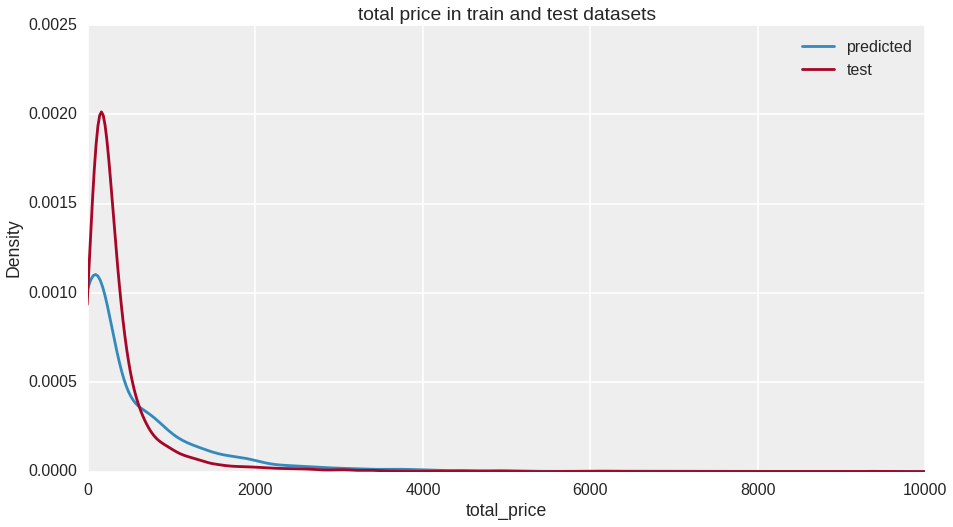

In [15]:
import statsmodels.api as sm
from copy import deepcopy
sns.set_context("poster")
plt.figure(figsize=(15,8))

# randomly pick up the same number as in the train case of 'total_price' values
test_price=deepcopy(df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:])
model = sm.OLS.from_formula("total_price ~book_duration+age+reise_dauer + no_of_persons + stars + Buch_anzahl", df.dataset.loc[df.dataset.index != 8,:])
result=model.fit()

test_price=test_price.dropna()

X=test_price[['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age']]
test_price['pred_total_price'] = result.predict(X)

pred_price=test_price['pred_total_price']

pred_price.plot(kind='kde',xlim=(0,10000),legend=True,label='predicted')
test_price['total_price'].plot(kind='kde',xlim=(0,10000),legend=True,label='test')

pl.xlabel('total_price')
pl.title('total price in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'predicted_total_price_test'+'.png')


### 'Scaling' Effect in the predictions

It is clear that predictions do not satisfy our expectations. We have calculated that difference between mean values 
of the test and predicted `total_price` should be around 3050, however we have

In [16]:
print 'median diff: %.3f'%(pred_price.median()-test_price['total_price'].median())
print 'mean diff: %.3f'%(pred_price.mean()-test_price['total_price'].mean())

median diff: -22.659
mean diff: 137.381


Why does it happen? The problem is that our model is based on features 
`book_duration+reise_dauer + no_of_persons + stars + Buch_anzahl` which  have different scales in the train and test
datasets:

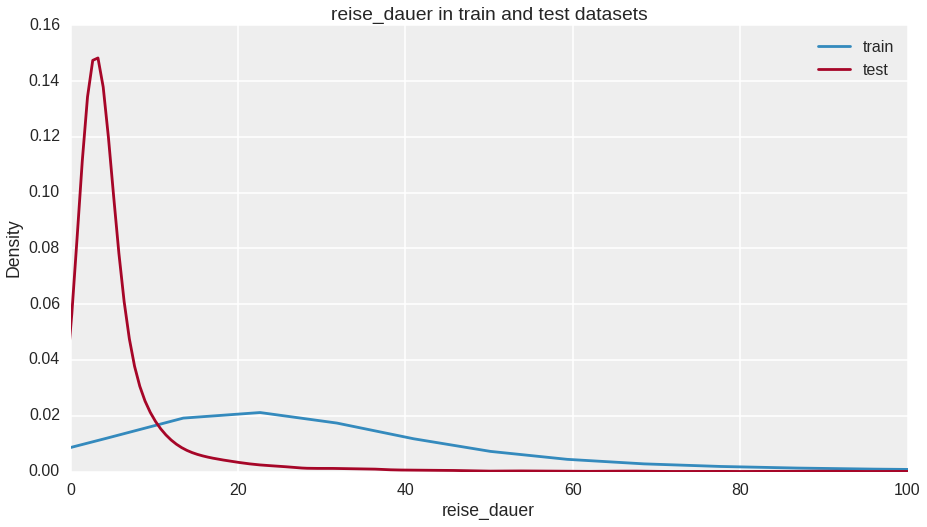

In [17]:
# reise_dauer
sns.set_context("poster")
plt.figure(figsize=(15,8))

train_reise_dauer =df.dataset['reise_dauer']

# randomly pick up the same number as in the train case of 'total_price' values 
test_reise_dauer=df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),'reise_dauer']


train_reise_dauer.plot(kind='kde',xlim=(0,100),legend=True,label='train')
test_reise_dauer.plot(kind='kde',xlim=(0,100),legend=True,label='test')
pl.xlabel('reise_dauer')
pl.title('reise_dauer in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'reise_dauer'+'.png')


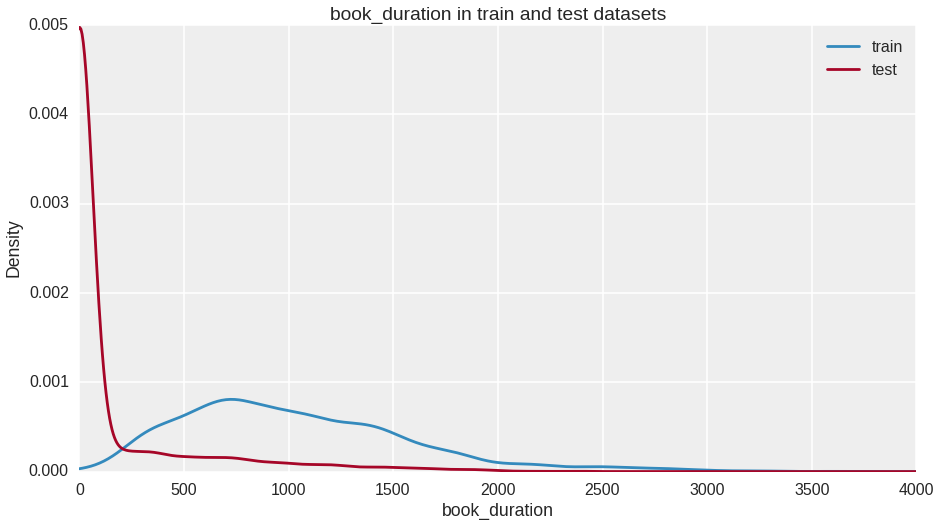

In [18]:
# book_duration
sns.set_context("poster")
plt.figure(figsize=(15,8))

train_reise_dauer =df.dataset['book_duration']

# randomly pick up the same number as in the train case of 'total_price' values 
test_reise_dauer=df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),'book_duration']


train_reise_dauer.plot(kind='kde',xlim=(0,4000),legend=True,label='train')
test_reise_dauer.plot(kind='kde',xlim=(0,4000),legend=True,label='test')
pl.xlabel('book_duration')
pl.title('book_duration in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'book_duration'+'.png')

We need a standard normalization of the features

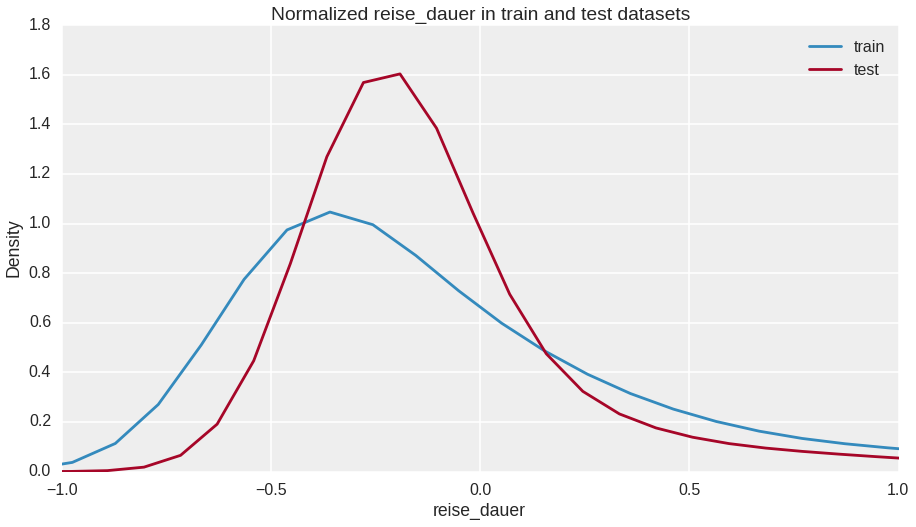

In [19]:
import copy
features  = ['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age']

# compare 3 choices: uncleaned, slightly cleaned and totaly cleaned train datasets

#data = copy.deepcopy(df.dataset)
data = copy.deepcopy(df.dataset.loc[np.delete(df.dataset.index.values,outliers_indexes.values),:]) # it seems to be the best choice 
#data = copy.deepcopy(cleaned_train_data)

test_data=copy.deepcopy(df_test.dataset.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:])
fml = "total_price ~ "

# normalization of the data
for vname in features:
    data.loc[:,vname] = (data[vname] - data[vname].mean()) / data[vname].std()
    test_data.loc[:,vname] = (test_data[vname] - test_data[vname].mean()) / test_data[vname].std()
    fml+=vname+" + "

fml = fml[:-2] # remove last '+'



# reise_dauer
sns.set_context("poster")
plt.figure(figsize=(15,8))

train_reise_dauer =data['reise_dauer']

# randomly pick up the same number as in the train case of 'total_price' values 
test_reise_dauer=test_data['reise_dauer']


train_reise_dauer.plot(kind='kde',xlim=(-1,1),legend=True,label='train')
test_reise_dauer.plot(kind='kde',xlim=(-1,1),legend=True,label='test')
pl.xlabel('reise_dauer')
pl.title('Normalized reise_dauer in train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'reise_dauer_normalized'+'.png')

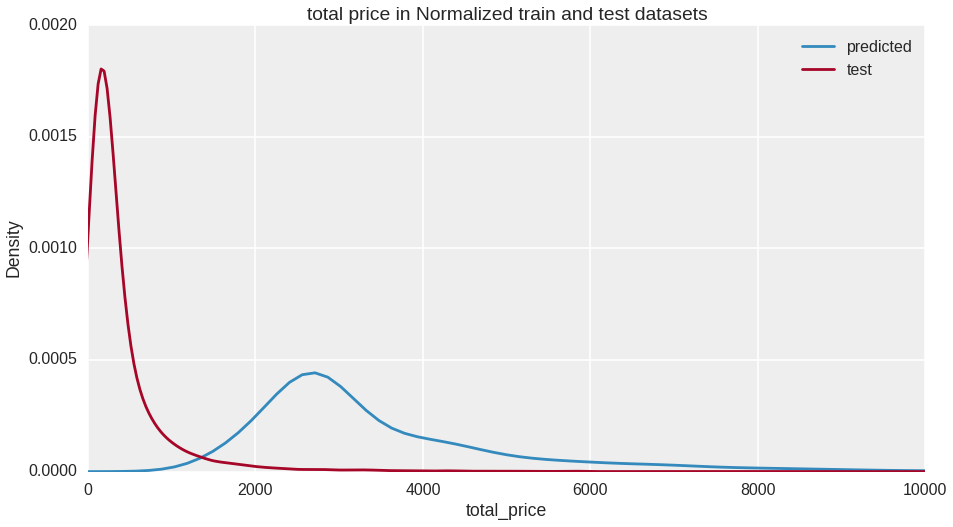

In [20]:
#After normalization

sns.set_context("poster")
plt.figure(figsize=(15,8))

model = sm.OLS.from_formula(fml, data)
result=model.fit()

test_data=test_data.dropna()
X=test_data[['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age']]
test_data.loc[:,'pred_total_price'] = result.predict(X)

pred_price=test_data['pred_total_price']

pred_price.plot(kind='kde',xlim=(0,10000),legend=True,label='predicted')
test_data['total_price'].plot(kind='kde',xlim=(0,10000),legend=True,label='test')

pl.xlabel('total_price')
pl.title('total price in Normalized train and test datasets')
pl.legend()
pl.savefig(plots_dir+prefix+'predicted_total_price_test_normalized_datasets'+'.png')

In [21]:
print 'median diff: %.3f'%(pred_price.median()-test_data['total_price'].median())
print 'mean diff: %.3f'%(pred_price.mean()-test_data['total_price'].mean())

median diff: 2648.394
mean diff: 3230.969


It is much closer to our expectations.

### Selection of the best customers with Generelazed Linear Model

Let's select the best customers. 
First, we calculate the $\delta = totalprice\_predicted - total\_price$ for each customer.
Then we reorder the obtained result in the descending order and select the first 100K customers.

In [22]:
import time
from copy import deepcopy
start_time = time.time()
cols_to_save=['predicted','total_price','delta','ClusterID']

data = deepcopy(df.dataset.loc[np.delete(df.dataset.index.values,outliers_indexes.values),:])
test_data=deepcopy(df_test.dataset)


# normalization of the test data. It's important for linear models!
for vname in features:
    data[vname] = (data[vname] - data[vname].mean()) / data[vname].std()
    test_data[vname] = (test_data[vname] - test_data[vname].mean()) / test_data[vname].std()


# our 'prediction' calculator
def df_predict(df,name,train_cols,target,est):                
        
        predicted = est.predict(df[train_cols])
        targets = df[target].as_matrix()
        df['predicted'],df['delta']=predicted,predicted-targets        
        return df



# we divide the big test dataset in groups of entries: each group of 70K entries
# such division should help us to save memory

groups=[]


step = 70000  # 70K per the group
start= step
prev=0
for i in xrange(start,len(test_data),step):
      
    groups+=[(str(i),test_data[prev:i])]
    prev=i

groups+=[(str(len(test_data)),test_data[prev:])]




results=[]
print 'number of groups: ',len(groups)

for name, group in groups:
    print 'processing the group ',name,' ....'
    results += [df_predict(group,name,features,'total_price',result).loc[:,cols_to_save]]


test_data=pd.concat(results)    
print 'time required %.3f seconds'% (time.time()-start_time)



# sorting the obtained result by delta
test_data = test_data.sort_index(by='delta',ascending=False)
test_data = test_data.reset_index()



# print first 3 entries
test_data.head(3)

number of groups:  7
processing the group  70000  ....
processing the group  140000  ....
processing the group  210000  ....
processing the group  280000  ....
processing the group  350000  ....
processing the group  420000  ....
processing the group  465579  ....
time required 1.516 seconds


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index      predicted  total_price          delta  ClusterID
0     134  200964.147930      4516.14  196448.007930       7890
1  145866  174313.394548     35843.56  138469.834548    2555898
2   88395  154449.366843     19691.08  134758.286843    1528761

One control plot can be useful to look at. What is the distribution of the $\delta$?

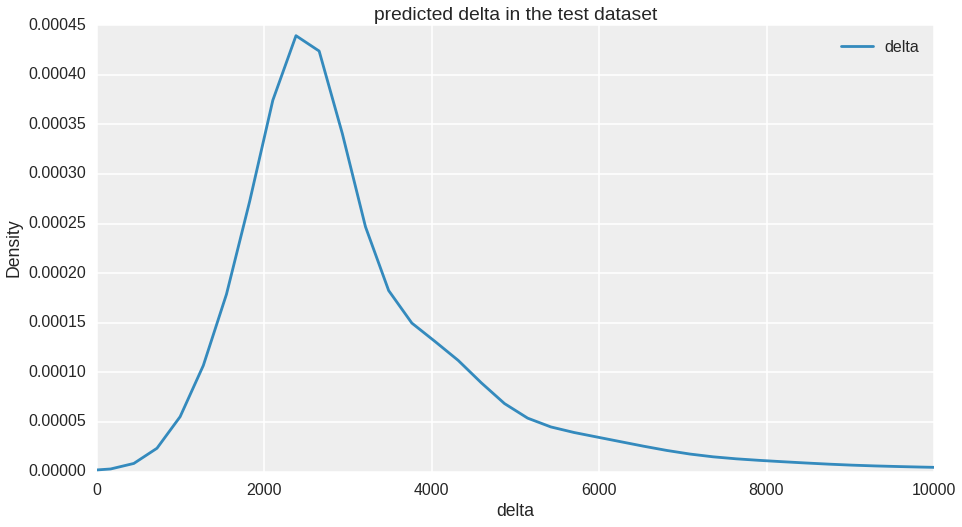

In [23]:
sns.set_context("poster")
plt.figure(figsize=(15,8))

test_data_to_plot=test_data.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:]

test_data_to_plot['delta'].plot(kind='kde',xlim=(0,10000),legend=True,label='delta')


pl.xlabel('delta')
pl.title('predicted delta in the test dataset')
pl.legend()
pl.savefig(plots_dir+prefix+'predicted_delta_test'+'.png')

So the median and mean values seem to be OK:

In [24]:
print " Mean value of the delta:  %.3f"%test_data['delta'].mean()
print " Median value of the delta:  %.3f"%test_data['delta'].median()

 Mean value of the delta:  3237.139
 Median value of the delta:  2592.723


Only one thing should be done additionaly: we need to cut the long tail on the right side of the median.
Let's remove 5% of tail:


<div class=warn>
**WARNING:** Shall we do that? (a question to Ehsan)
<div/>


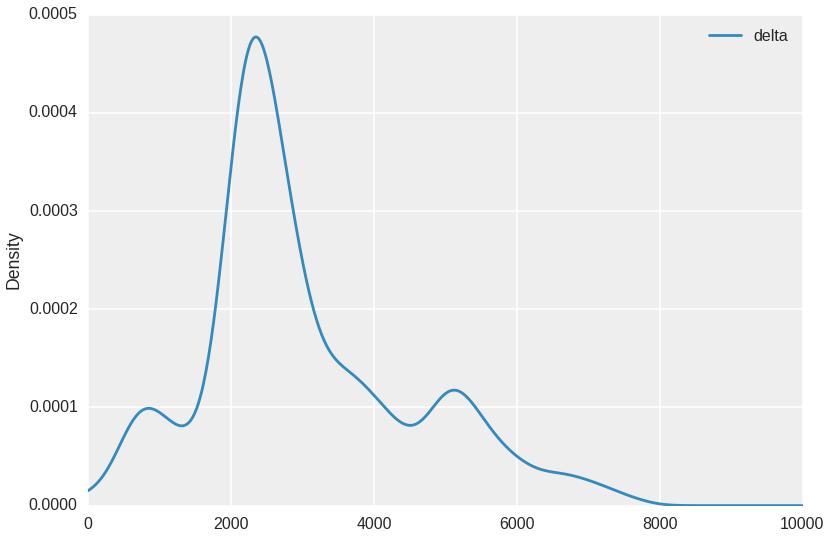

In [28]:
test_data=test_data[test_data.delta<test_data.delta.quantile(.95)]
test_data_to_plot=test_data.loc[np.random.randint(0,len(df_test.dataset),len(df.dataset)),:]
test_data_to_plot['delta'].plot(kind='kde',xlim=(0,10000),legend=True,label='delta')

### Saving a list of customers to the file
------------------------

In [25]:
file_for_results='predicted_GLM'
how_many_best_customers = 100000


# save a result to the file 
test_data[cols_to_save][:how_many_best_customers if len(test_data)>how_many_best_customers else len(test_data) ].to_csv(data_dir+file_for_results+'.csv', sep=',',index=False,encoding='utf-8') 

# print a few customers with highest 'delta'
test_data[cols_to_save][:how_many_best_customers if len(test_data)>how_many_best_customers else len(test_data) ].head(10)


predicted  total_price          delta  ClusterID
0  200964.147930     4516.140  196448.007930       7890
1  174313.394548    35843.560  138469.834548    2555898
2  154449.366843    19691.080  134758.286843    1528761
3  170259.075650    36257.790  134001.285650    1979731
4  127193.329080     8106.720  119086.609080     785888
5  130453.326921    12443.540  118009.786921    1533551
6  133952.515127    20227.822  113724.693127    1978031
7  145616.684728    46680.187   98936.497728     384687
8  101306.396835    11630.830   89675.566835    5780424
9   90210.561937     1786.450   88424.111937    4679505

Here we want to understand what is the loss in delta if we choose next 100K best customers 

In [26]:
# Some statistics on the best first 100K customers 
test_data[cols_to_save[:-1]][:how_many_best_customers if len(test_data)>how_many_best_customers else len(test_data) ].describe()

predicted    total_price          delta
count  100000.000000  100000.000000  100000.000000
mean     6795.959004     891.427298    5904.531707
std      3825.034624    1132.556610    3102.968000
min      3984.075785       5.000000    3961.007279
25%      4707.945728     318.000000    4260.477054
50%      5793.838552     575.019500    5041.622171
75%      7481.197099    1062.521000    6419.770259
max    200964.147930   57851.484000  196448.007930

In [27]:
mean_delta_first_100K=test_data['delta'][:how_many_best_customers if len(test_data)>how_many_best_customers else len(test_data) ].describe()['mean']
mean_delta_next_100K=test_data['delta'][how_many_best_customers:how_many_best_customers+how_many_best_customers ].describe()['mean']

print 'loss in delta from choosing next 100K best customers on average is %.3f'%(mean_delta_first_100K-mean_delta_next_100K)
print '\nWe expect that the customer from the first group will book in %.3f times more than the customer from the\
 second group'%(mean_delta_first_100K/mean_delta_next_100K)


loss in delta from choosing next 100K best customers on average is 2675.214

We expect that the customer from the first group will book in 1.828 times more than the customer from the second group


### Comparison of DecisionTrees and GLM predictions

In [28]:
best_customers_DT = 'predicted_DT.csv'
best_customers_GLM = 'predicted_GLM.csv'


# read customers predicted by DT
#predictions_DT = np.genfromtxt(data_dir+best_customers_DT, delimiter=',', names=True,dtype=('float','float','float','int'))
predictions_DT = np.loadtxt(data_dir+best_customers_DT, delimiter=',',skiprows=1,
                             #dtype={'names': ('predicted', 'total_price', 'delta','CustomerID'),
                             #'formats': ('float', 'float', 'float','int')}
                             )                            
predicted_customers_DT=predictions_DT.T[3]
predicted_customers_DT = predicted_customers_DT.astype('int')

# read customers predicted by GLM
predictions_GLM = np.loadtxt(data_dir+best_customers_GLM, delimiter=',',skiprows=1,
                             #dtype={'names': ('predicted', 'total_price', 'delta','CustomerID'),
                             #'formats': ('float', 'float', 'float','int')}
                             )                            
predicted_customers_GLM=predictions_GLM.T[3]
predicted_customers_GLM = predictions_GLM.astype('int')

print 'Overlapping of two types of predictions is ', float(np.intersect1d(predicted_customers_DT,predicted_customers_GLM).shape[0])/max(len(predicted_customers_DT),len(predicted_customers_GLM))




Overlapping of two types of predictions is  0.30235


... a quite small fraction (:-. The possible reason of this fact is that I have used different features in 
DT and GLM. 
<div class=warn>
**WARNING:** What shall we do ? (a question to Ehsan)
<div/>
At least, I can try to apply GLM to the same feature space as  in the DT case.

###Cross-validation of the GLM model
-------------------------

The aim of this study is to understand the **dependence** of the $R^2$  determination coefficient in the *~train* data (*complementary train* data, i.e not used in the GLM fitting) on:

* sample size used in the training 
* the outlier cleaning.

In [29]:
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.cross_validation import train_test_split
import copy

datasets=[copy.deepcopy(df.dataset),copy.deepcopy(df.dataset.loc[np.delete(df.dataset.index.values,outliers_indexes.values),:]),copy.deepcopy(cleaned_train_data)]
features  = ['book_duration','reise_dauer','no_of_persons','stars','Buch_anzahl','age']


# to store all future results
obtained_results_all=None



# test datasets
for i,data in enumerate(datasets):
    fml = "total_price ~ "

    
# to store intermediate results    
    obtained_results={                
                 "r2_scores":[],
                 "mae":[],
                 'sample_type':[],
                 'sample_size':[],
                 }

    
    # normalization of the data
    for vname in features:
        data.loc[:,vname] = (data[vname] - data[vname].mean()) / data[vname].std()
        fml+=vname+" + "

    fml = fml[:-2] # remove last '+'
    
    
    # target data
    y = data['total_price'].as_matrix()
    
    
    # features
    X = data[features].as_matrix()
    
    # get train/test samples: 80% goes to the 'train' dataset, 20% -- to the 'test' dataset
    for test_size  in [0.05,0.1,0.3,0.5,0.7,0.9,0.95]:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=1)
    
        # create a train dataframe
        dataframe_train=np.c_[y_train,X_train]
        dataframe_train = pd.DataFrame(dataframe_train,columns=['total_price']+features)
    
        # create a test dataframe
        dataframe_test=np.c_[y_test,X_test]
        dataframe_test = pd.DataFrame(dataframe_test,columns=['total_price']+features)
    
        # train GLM
        model = sm.OLS.from_formula(fml, dataframe_train)
        result=model.fit()

        # R2 score and MAE
        predictions=result.predict(dataframe_test[features])

        # save results
        obtained_results['r2_scores'] += [r2_score(y_test, predictions)]
        obtained_results['mae'] += [mean_absolute_error(y_test, predictions)]
        obtained_results['sample_type'] += [i]
        obtained_results['sample_size'] += [(1.-test_size)]
    
    

    obtained_results=pd.DataFrame(obtained_results)    

    
    if (obtained_results_all is not None):
        obtained_results_all=obtained_results_all.append(obtained_results,ignore_index=True) 
        
    else:
        obtained_results_all = copy.deepcopy(obtained_results)
    
    


types_of_samples={
        0:'uncleaned',
        1:'removed_largest_outlier',
        2:'removed_chi2_outliers'
    }
obtained_results_all=obtained_results_all.sort_index(by='r2_scores',ascending=False)
obtained_results_all['sample_type'] = obtained_results_all['sample_type'].apply(lambda x: types_of_samples[x])
obtained_results_all=obtained_results_all.reset_index()
obtained_results_all


NameError: name 'cleaned_train_data' is not defined

OK. Done. What do we see? The first 4 lines with $R^2$ about 0.90  in the table are occupied by `uncleaned` train samples with relatively small sizes. Why?  I don't know... Perhaps, due to statistical fluctuations...
At least, these lines look suspecious for me.

But there are also good knews:

* We have reached  $R^2$  about 62%  with GLM in the `uncleaned` and `removed_largest_outlier` train samples
* I belive that the `removed_largest_outlier` train sample is the best choice




##Conclusions
-----------------------

A lot of work and studies with GLM and OLS were done. I have tested different modes of the modeling and plotted different statistics and distributions of the model parameters. It seems that the modeling was reasonable.
We have created  a list of the best customers.